<a href="https://colab.research.google.com/github/Damilolaori/Final-Project-/blob/Damilolaori-patch-1-Hybrid-model-Architecture/Oluwadamilola_Abimbola_Orimoogunje_21019292.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING** **NECESSARY** **LIBRARIES**

In [1]:
# install libraries
!pip install keras-tuner
!pip install ta

# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from scipy.stats import t, skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=df7e57fd3e57a8299e8dac316cc514920b1a3a7969e2da57753b0dfcc4739068
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


<ipython-input-1-ef4053ed86dc>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Setting stocks and intervals
stocks = ["VOD.L", "HSBA.L", "SHEL.L"]
start_date = "2013-01-01"
end_date = "2023-12-31"

# Initialize an empty list to collect DataFrames
stock_data_list0 = []

# Loop through each stock, download the data, and add it to the list
for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)
    data['Stock'] = stock
    stock_data_list0.append(data)

# Concatenate all the DataFrames in the list into a single DataFrame
stock_df = pd.concat(stock_data_list0)

# Display the resulting DataFrame
stock_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Stock
Date,,,,,,,
2013-01-02,163.537201,165.153198,161.034805,164.162704,69.963249,83340593,VOD.L
2013-01-03,164.631897,164.830002,162.598801,164.110596,69.941063,71870539,VOD.L
2013-01-04,163.693497,169.288300,163.693497,166.873596,71.118591,76183361,VOD.L
2013-01-07,166.456497,168.106995,166.352295,166.456497,70.940834,71771713,VOD.L
2013-01-08,170.053604,171.767700,169.323807,169.323807,72.162827,140972109,VOD.L


In [3]:
# Basic Statistics
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,8.331000e+03
mean,935.307695,944.565694,925.288769,935.099725,678.636945,4.007820e+07
std,845.083933,853.012738,837.197642,845.005188,663.264821,4.575528e+07
min,66.019997,66.480003,3.045000,64.720001,60.919899,0.000000e+00
25%,218.000000,220.025002,215.715996,217.850006,112.252522,1.072821e+07
50%,607.099976,612.099976,601.799988,606.700012,389.331329,2.610217e+07
75%,1804.000000,1820.500000,1777.750000,1805.000000,1187.859985,5.443034e+07
max,2784.500000,2801.000000,2757.500000,2772.500000,2649.824707,9.423232e+08


In [4]:
# checking missing values
stock_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Stock,0


**EXPLORATORY** **DATA** **ANALYSIS**

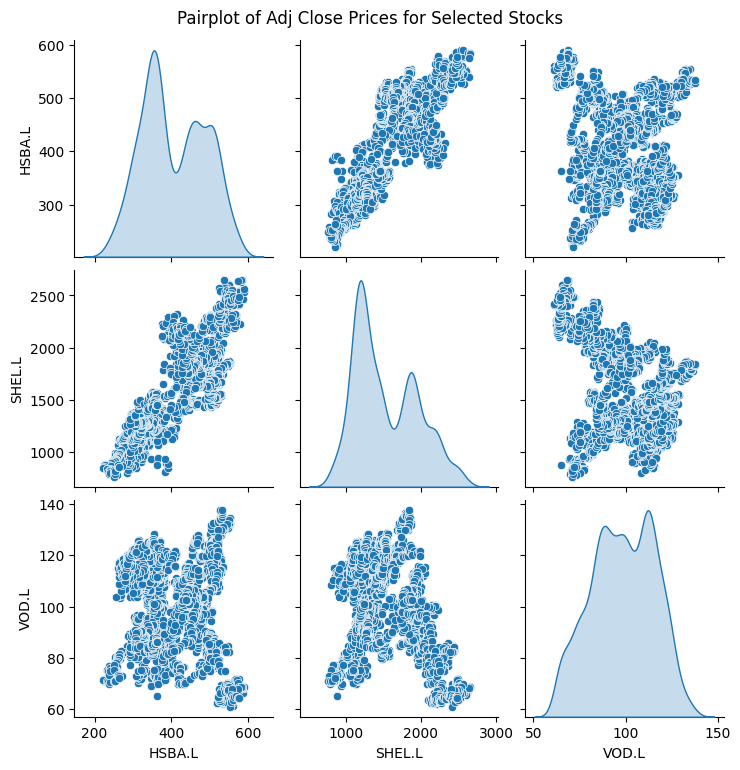

In [5]:
# Pivot the data to have 'Date' as the index and 'Stock' as columns for 'Adj Close'
adj_close_data = stock_df.pivot_table(index='Date', columns='Stock', values='Adj Close')

# Reset index to make 'Date' a column again (for seaborn compatibility)
adj_close_data.reset_index(inplace=True)

# Plotting the pairplot
sns.pairplot(adj_close_data, diag_kind='kde')
plt.suptitle('Pairplot of Adj Close Prices for Selected Stocks', y=1.02)
plt.show()


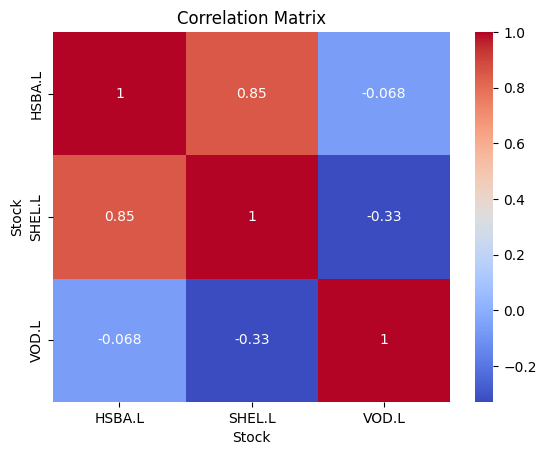

In [6]:
# Correlation Analysis
# Pivot the data to get a DataFrame with stocks as columns
pivot_data = stock_df.pivot_table(index='Date', columns='Stock', values='Adj Close')

# Calculate the correlation matrix
correlation_matrix = pivot_data.corr()

# Plot the correlation matrix using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**TREND** **AND** **VOLATILITY** **ANALYSIS**

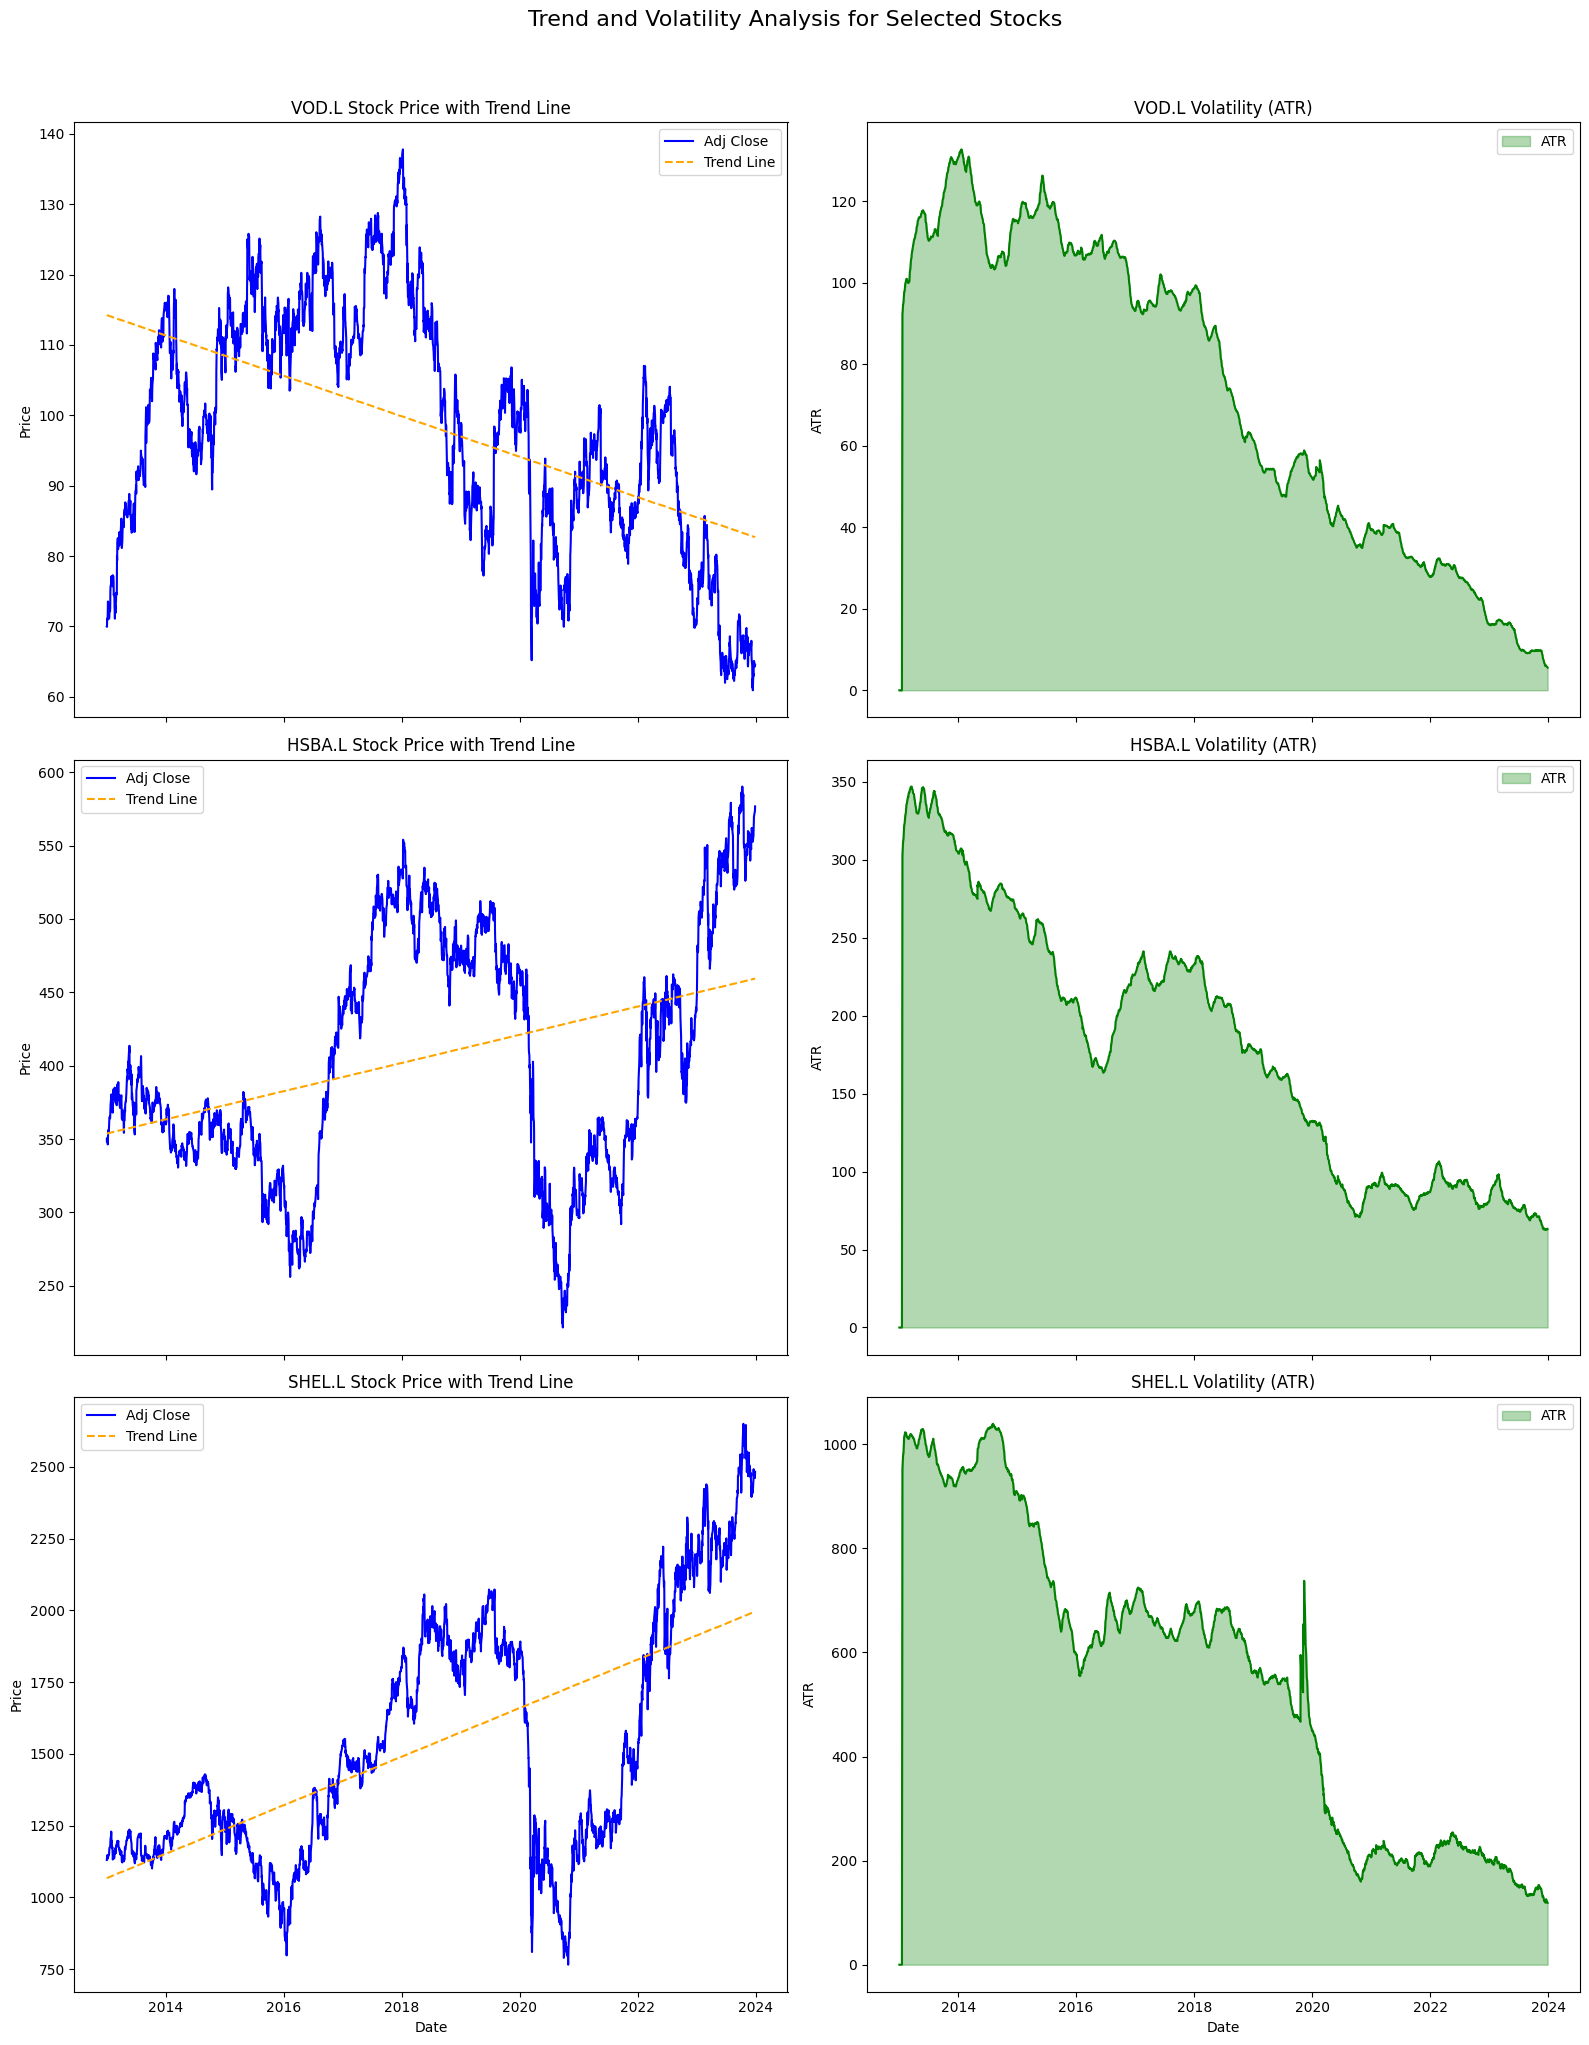

In [7]:
# Initialize subplots with proper figure size and spacing
fig, axs = plt.subplots(len(stocks), 2, figsize=(16, 20), sharex='col')

# Loop through each stock for analysis
for i, stock in enumerate(stocks):
    # Subset data for the current stock
    stock_data_subset = stock_df[stock_df['Stock'] == stock]
    dates = np.array(range(len(stock_data_subset)))

    # Trend analysis using linear regression
    close_prices = stock_data_subset['Adj Close']
    slope, intercept, r_value, p_value, std_err = linregress(dates, close_prices)
    trend_line = slope * dates + intercept

    # Plotting trend line
    axs[i, 0].plot(stock_data_subset.index, close_prices, label='Adj Close', color='blue')
    axs[i, 0].plot(stock_data_subset.index, trend_line, label='Trend Line', linestyle='--', color='orange')
    axs[i, 0].set_title(f'{stock} Stock Price with Trend Line')
    axs[i, 0].set_ylabel('Price')
    axs[i, 0].legend()

    # Volatility analysis using Average True Range (ATR)
    atr_indicator = AverageTrueRange(high=stock_data_subset['High'], low=stock_data_subset['Low'],
                                     close=stock_data_subset['Adj Close'], window=14)
    atr_values = atr_indicator.average_true_range()

    # Plotting ATR
    axs[i, 1].fill_between(stock_data_subset.index, 0, atr_values, label='ATR', color='green', alpha=0.3)
    axs[i, 1].plot(stock_data_subset.index, atr_values, linestyle='-', color='green')
    axs[i, 1].set_title(f'{stock} Volatility (ATR)')
    axs[i, 1].set_ylabel('ATR')
    axs[i, 1].legend()

# Set common X-axis label for the last row of subplots
for ax in axs[-1, :]:
    ax.set_xlabel('Date')

# Adjust layout, add overall title, and display
plt.suptitle('Trend and Volatility Analysis for Selected Stocks', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [8]:
# define a function that plot a T distribution of the stock data
def T_distribution_plot(stock, ax):
    """This plots t-distribution using the returns of each stocks"""
    returns = stock_df[stock_df['Stock'] == stock]['Adj Close'].pct_change().dropna()

    x_list = np.linspace(returns.min(), returns.max(), 100)
    params = t.fit(returns)
    df, loc, scale = params
    y_list = t.pdf(x_list, df, loc, scale)

    ax.plot(x_list, y_list, label='T Dist')
    ax.hist(returns, bins=100, density=True, alpha=0.5, label=f'{stock} Returns')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'T Distribution of Returns for {stock}')
    ax.legend(bbox_to_anchor=(1.0, 1.0))

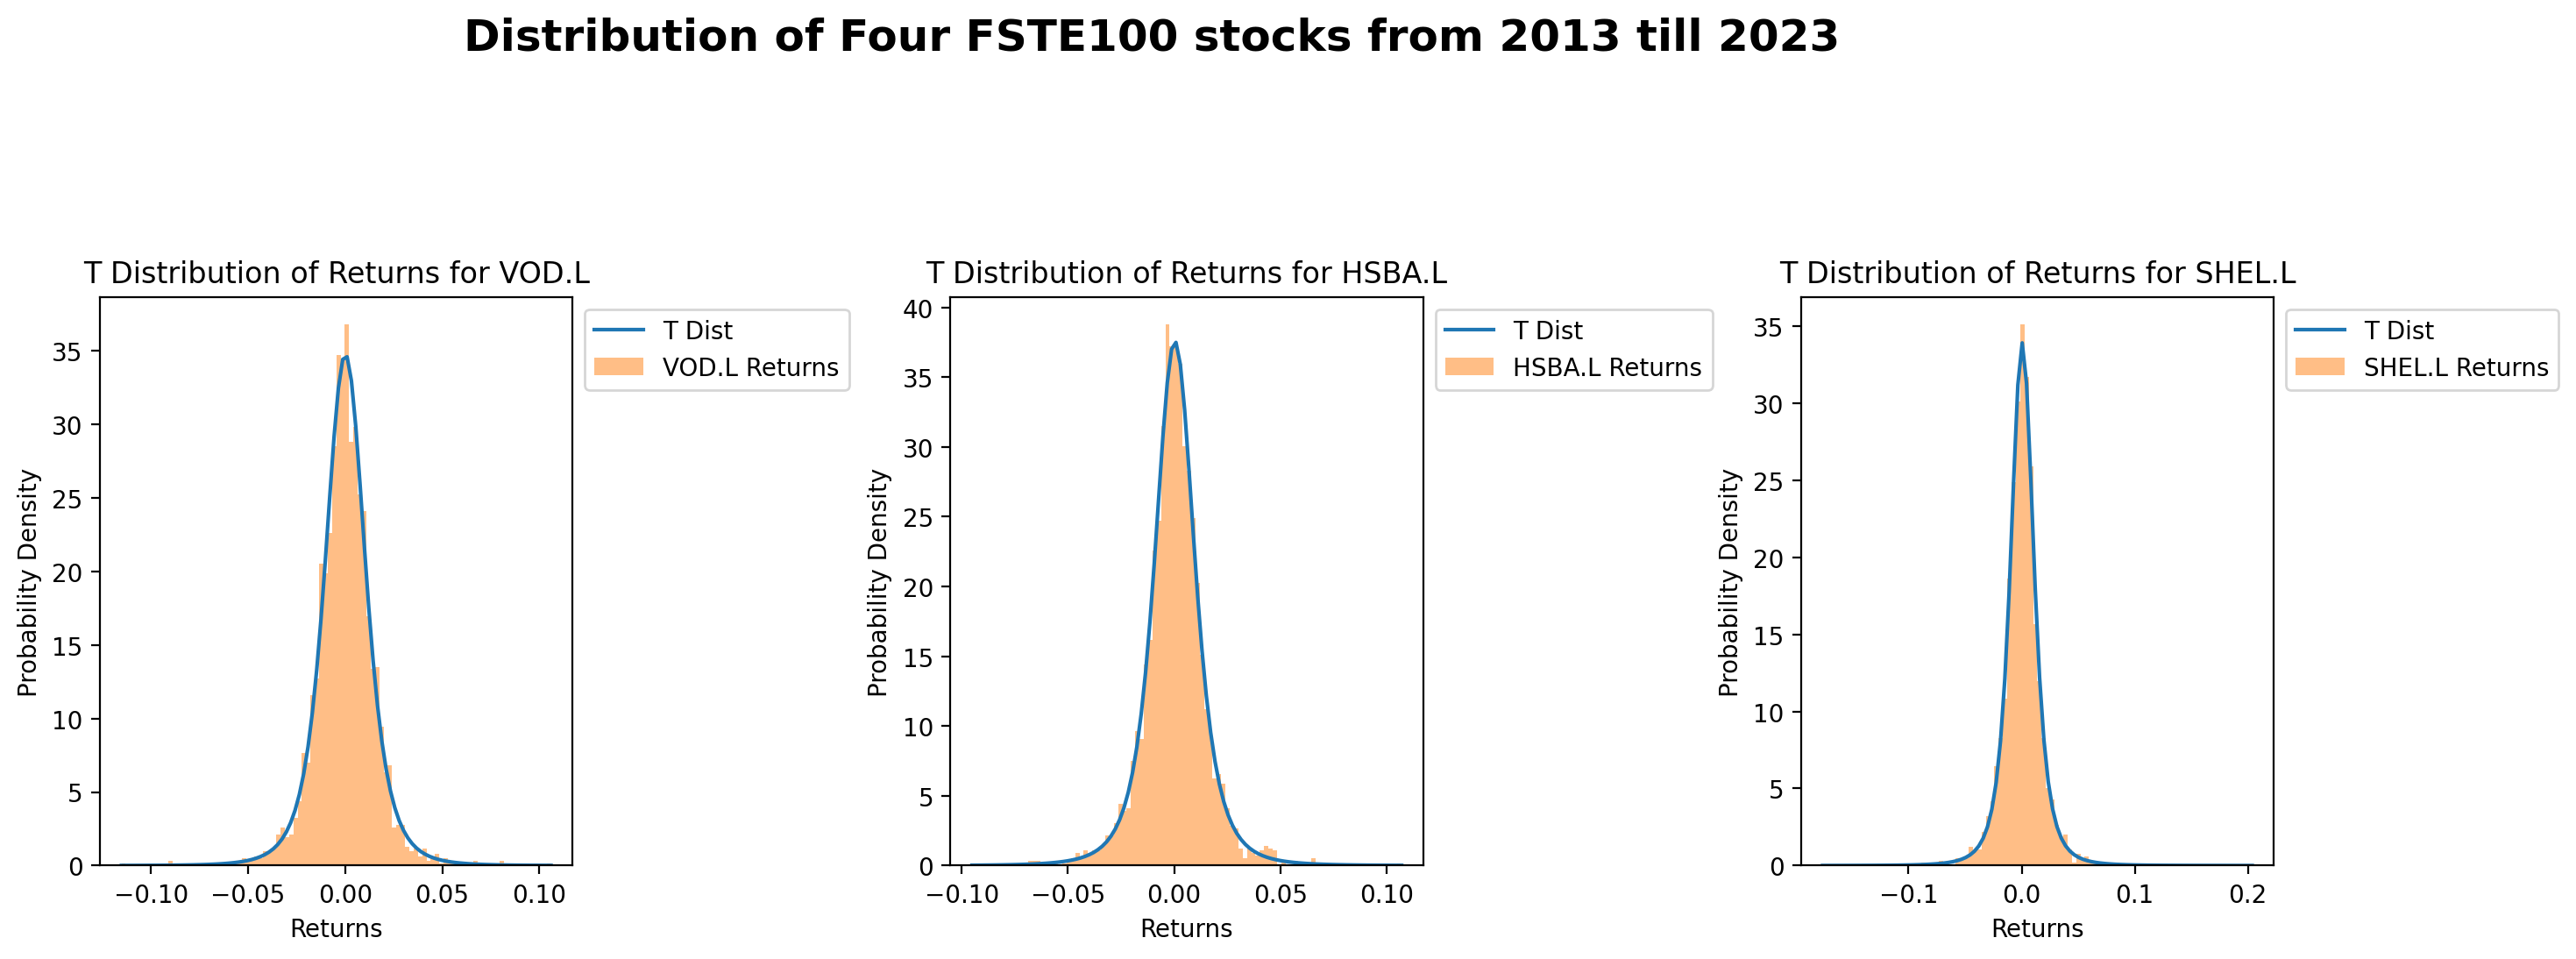

In [9]:
# create a gridspec with rows 2 and 3 columns for distribution of the stocks
fig = plt.figure(figsize=(16,16), dpi=200)
fig.suptitle('Distribution of Four FSTE100 stocks from 2013 till 2023', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=3, ncols=3, wspace=0.8, hspace=0.4)

# Plot distribution for VOD.L
ax1 = plt.subplot(gs[0,0])
T_distribution_plot('VOD.L', ax=ax1)

# Plot distribution for MKS
ax2 = plt.subplot(gs[0,1])
T_distribution_plot('HSBA.L', ax=ax2)

# Plot distribution for HSBA
ax3 = plt.subplot(gs[0,2])
T_distribution_plot('SHEL.L', ax=ax3)

plt.show()

#**SKEWNESS** **AND** **KURTOSIS**

In [10]:
# the returns dataframe is used to calculate the skewness and kurtosis of each stock
# create dataframe stock name in the 'stock' column
stock_names = pd.DataFrame({'Stock': ['VOD.L', 'HSBA.L', 'SHEL.L',]})

# Empty DataFrame to store returns
stock_returns = pd.DataFrame()
# Loop through stock names and calculate returns
for stock in stock_names['Stock']:
  returns = stock_df[stock_df['Stock'] == stock]['Adj Close'].pct_change()
  # Add returns to the DataFrame
  stock_returns[stock] = returns

# check the first 5 rows of the stock returns dataframe
stock_returns.dropna(inplace=True)
stock_returns.head()

,VOD.L,HSBA.L,SHEL.L
Date,,,
2013-01-03,-0.000317,-0.004807,0.007299
2013-01-04,0.016836,0.007698,0.007246
2013-01-07,-0.002499,-0.002097,-0.006266
2013-01-08,0.017226,-0.010507,-0.004203
2013-01-09,0.019088,0.016232,0.004221


In [11]:
#Function to calculate skewness and kurtosis
def calculate_skewness_and_kurtosis(data):
    """This calculates the skewness and kurtosis of each stock returns and also appends the result to a dataframe called results"""
    # Create an empty DataFrame to store the results
    results = pd.DataFrame(index=stock_returns.columns, columns=['Skewness', 'Kurtosis'])

    # Iterate over each stock
    for stock in stock_returns.columns:
        # Calculate the skewness and kurtosis
        skewness = round(skew(stock_returns[stock].dropna()), 2)
        kurt = round(kurtosis(stock_returns[stock].dropna()), 2)

        # Store the results in the DataFrame
        results.loc[stock, 'Skewness'] = skewness
        results.loc[stock, 'Kurtosis'] = kurt

    return results

# pass the returns dataframe to the calculate skewness and kurtosis function
calculate_skewness_and_kurtosis(data=stock_returns)

,Skewness,Kurtosis
VOD.L,0.07,5.92
HSBA.L,0.07,5.16
SHEL.L,-0.08,14.95


## **Simple** **Moving** **Average** (**Traditional** **Method**)

In [12]:
# Defining the stock tickers and date range
stocks = ["VOD.L", "HSBA.L", "SHEL.L"]
start_date = "2013-01-01"
end_date = "2023-12-31"

# Function to download stock data and calculate SMA
def calculate_sma_baseline(stock, sma_window):
    # Download stock data
    data = yf.download(stock, start=start_date, end=end_date)
    data['Stock'] = stock

    # Calculating Simple Moving Average (SMA)
    data['SMA'] = data['Adj Close'].rolling(window=sma_window).mean()
    # Shift SMA to align it with the predicted period (1-day ahead)
    data['SMA_Prediction'] = data['SMA'].shift(1)

    # Drop rows with NaN values (due to rolling calculation)
    data.dropna(inplace=True)

    return data

# Calculating SMA for each stock
sma_window = 20  # Example: 20-day SMA
sma_data = []

for stock in stocks:
    stock_data = calculate_sma_baseline(stock, sma_window)
    sma_data.append(stock_data)

# Concatenate the data for all stocks
all_sma_data = pd.concat(sma_data)

# Displaying a sample of the SMA data
all_sma_data.head()


# Function to split data into training and testing sets
def split_data(stock_df, test_size=0.2):

    # The 'SMA_Prediction' is our target variable for prediction
    train_df, test_df = train_test_split(stock_df, test_size=test_size, shuffle=False)
    return train_df, test_df

# Split the data for each stock
train_test_data = {}

for stock in stocks:
    stock_df = all_sma_data[all_sma_data['Stock'] == stock]
    train_df, test_df = split_data(stock_df)
    train_test_data[stock] = {'train': train_df, 'test': test_df}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [13]:
# Function to make predictions and evaluate on test data
def predict_and_evaluate_sma(train_df, test_df):
    # Since SMA is a pre-calculated moving average, we just need to evaluate it on the test set
    y_test = test_df['Adj Close']
    y_pred = test_df['SMA_Prediction']

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return y_test, y_pred, mae, mse, rmse

# Predicting and evaluating SMA for each stock
sma_test_results = []

for stock, data in train_test_data.items():
    train_df = data['train']
    test_df = data['test']

    y_test, y_pred, mae, mse, rmse = predict_and_evaluate_sma(train_df, test_df)

    # Storing results
    sma_test_results.append({'Stock': stock, 'Model': 'SMA', 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

# Converting results to DataFrame
sma_test_results_df = pd.DataFrame(sma_test_results)
sma_test_results_df

,Stock,Model,MAE,MSE,RMSE
0,VOD.L,SMA,2.863752,13.531614,3.678534
1,HSBA.L,SMA,15.819116,401.809453,20.045185
2,SHEL.L,SMA,62.258576,6326.597981,79.539914


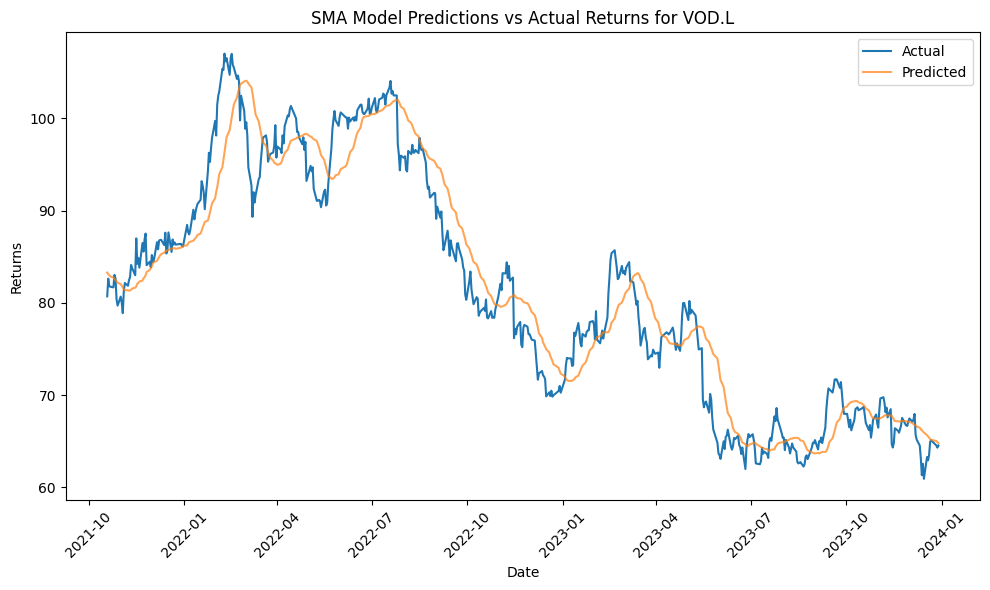

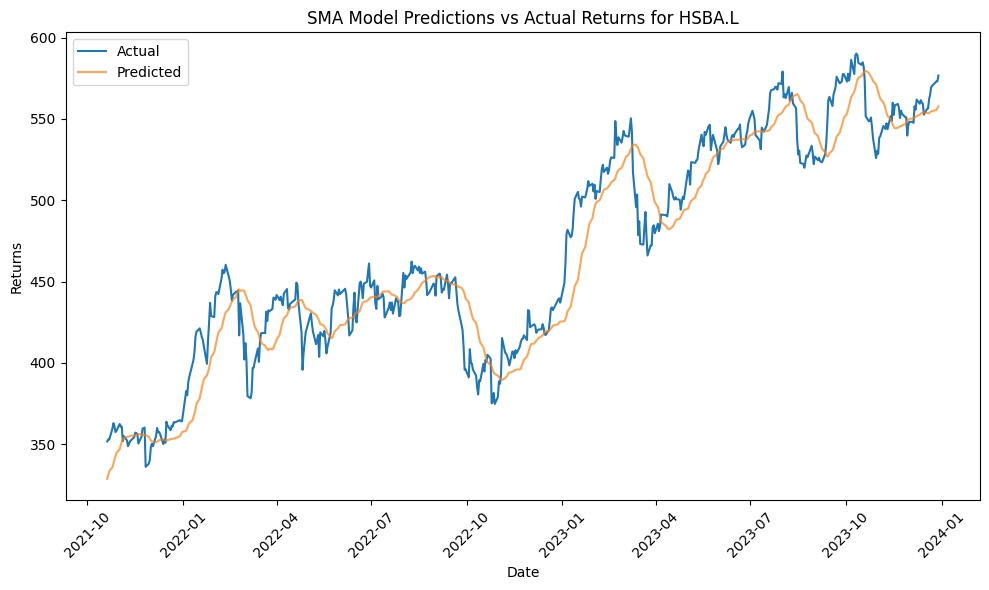

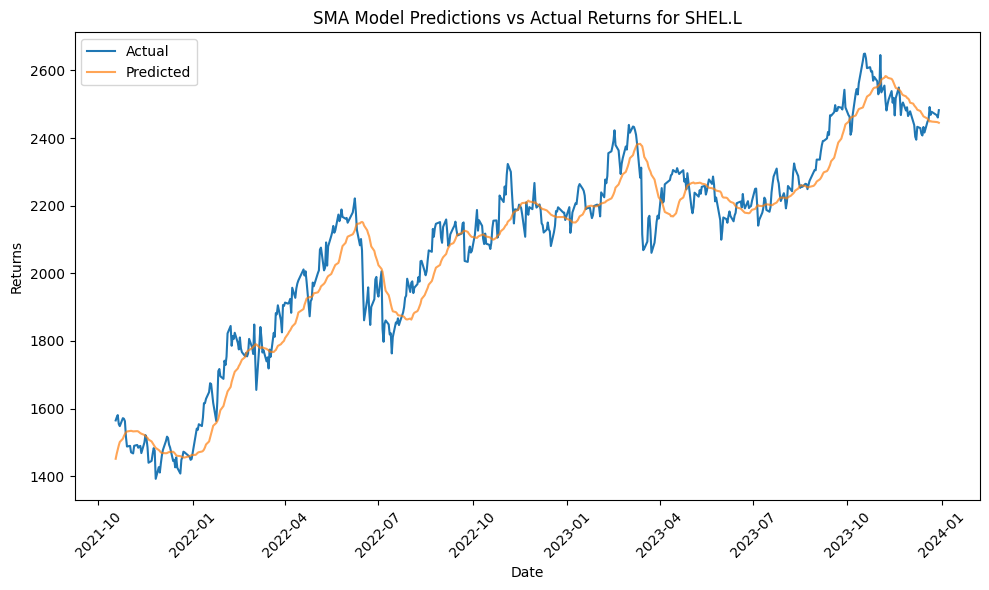

In [14]:
# Function to plot actual vs predicted values for SMA
def plot_sma_predictions(stock, y_test, y_pred, dates):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, y_pred, label='Predicted', alpha=0.7)
    plt.title(f'SMA Model Predictions vs Actual Returns for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for each stock
for stock, data in train_test_data.items():
    test_df = data['test']
    dates = test_df.index  # Assuming the index is Date
    y_test, y_pred = test_df['Adj Close'], test_df['SMA_Prediction']

    plot_sma_predictions(stock, y_test, y_pred, dates)


## **Calculation** **of** **Technical** **Indicators** **to** **be** **used** **as** **Features** **for** **the** **Models**

In [15]:
# Define Technical Indicator Functions
def moving_average(data, window=10):
    return data['Adj Close'].rolling(window=window).mean()

def exponential_moving_average(data, span=20):
    return data['Adj Close'].ewm(span=span, adjust=False).mean()

def macd(data):
    exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

def rsi(data, window=14):
    delta = data['Adj Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def bollinger_bands(data, window=20):
    ma = data['Adj Close'].rolling(window=window).mean()
    std = data['Adj Close'].rolling(window=window).std()
    bollinger_up = ma + (std * 2)
    bollinger_down = ma - (std * 2)
    return bollinger_up, bollinger_down


In [16]:
# Fetch the stock data for VOD.L Stock
stocks = ["VOD.L"]
start_date = "2013-01-01"
end_date = "2023-12-31"

# Initialize an empty list to collect DataFrames
stock_data_lists = []

# Loop through each stock, download the data, calculate indicators, and add to the list
for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)
    data['Stock'] = stock

    # Calculate Technical Indicators
    data['MA10'] = moving_average(data, window=10)
    data['MA50'] = moving_average(data, window=50)
    data['EMA'] = exponential_moving_average(data, span=20)
    data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data)
    data['RSI'] = rsi(data, window=14)
    data['Bollinger_Up'], data['Bollinger_Down'] = bollinger_bands(data, window=20)

    stock_data_lists.append(data)

# Concatenate all the DataFrames in the list into a single DataFrame
stock_df_vod = pd.concat(stock_data_lists)

# Drop any NaN values that may have been introduced
stock_df_vod.dropna(inplace=True)

# Display the resulting DataFrame
stock_df_vod.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down
Date,,,,,,,,,,,,,,,,
2013-03-12,193.252197,194.008102,191.636093,192.887299,82.205170,75925775,VOD.L,77.714993,74.600974,76.903600,1.871431,0.880926,0.990504,80.080524,82.778742,68.203282
2013-03-13,192.001099,192.418106,189.550903,190.020096,80.983246,90708176,VOD.L,78.477061,74.821374,77.292138,1.955242,1.095789,0.859452,79.548760,83.414120,68.038923
2013-03-14,187.726303,192.991592,187.726303,192.418106,82.005219,111626481,VOD.L,79.321331,75.062657,77.741003,2.080148,1.292661,0.787487,79.133048,84.256245,67.952199
2013-03-15,192.835205,195.681595,190.176498,191.062698,81.427574,130848813,VOD.L,79.985641,75.268837,78.092105,2.108224,1.455774,0.652451,75.774147,84.898801,67.996169
2013-03-18,187.726303,194.075897,187.726303,192.835205,82.182968,98076665,VOD.L,80.752152,75.493680,78.481711,2.166455,1.597910,0.568545,81.446441,85.598480,68.102988


In [17]:
# Fetch the stock data for HSBA.L Stock
stocks = ["HSBA.L"]
start_date = "2013-01-01"
end_date = "2023-12-31"

# Initialize an empty list to collect DataFrames
stock_data_listts = []

# Loop through each stock, download the data, calculate indicators, and add to the list
for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)
    data['Stock'] = stock

    # Calculate Technical Indicators
    data['MA10'] = moving_average(data, window=10)
    data['MA50'] = moving_average(data, window=50)
    data['EMA'] = exponential_moving_average(data, span=20)
    data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data)
    data['RSI'] = rsi(data, window=14)
    data['Bollinger_Up'], data['Bollinger_Down'] = bollinger_bands(data, window=20)

    stock_data_listts.append(data)

# Concatenate all the DataFrames in the list into a single DataFrame
stock_df_hsba = pd.concat(stock_data_listts)

# Drop any NaN values that may have been introduced
stock_df_hsba.dropna(inplace=True)

# Display the resulting DataFrame
stock_df_hsba.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down
Date,,,,,,,,,,,,,,,,
2013-03-12,733.900024,738.799988,729.400024,729.400024,383.219727,21394093,HSBA.L,380.471942,371.418423,379.493228,2.664548,2.797622,-0.133074,48.573760,389.004550,372.370169
2013-03-13,725.700012,727.799988,717.500000,726.599976,381.748718,15911246,HSBA.L,380.556012,372.058351,379.708036,2.537743,2.745646,-0.207903,54.678969,388.762063,372.386737
2013-03-14,733.000000,741.200012,731.099976,740.000000,388.788818,22230812,HSBA.L,381.007840,372.872704,380.572873,2.971078,2.790732,0.180345,57.921564,389.962555,372.016357
2013-03-15,734.000000,737.015991,720.099976,720.099976,378.333618,64550808,HSBA.L,380.587534,373.424363,380.359610,2.442693,2.721125,-0.278431,46.195638,389.868070,371.779840
2013-03-18,715.099976,725.500000,713.000000,720.200012,378.386139,23103224,HSBA.L,381.123431,373.991785,380.171661,2.005070,2.577914,-0.572844,53.214320,389.774960,371.568231


In [18]:
# Fetch the stock data for SHEL.L Stock
stocks = ["SHEL.L"]
start_date = "2013-01-01"
end_date = "2023-12-31"

# Initialize an empty list to collect DataFrames
stock_data_lissts = []

# Loop through each stock, download the data, calculate indicators, and add to the list
for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)
    data['Stock'] = stock

    # Calculate Technical Indicators
    data['MA10'] = moving_average(data, window=10)
    data['MA50'] = moving_average(data, window=50)
    data['EMA'] = exponential_moving_average(data, span=20)
    data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data)
    data['RSI'] = rsi(data, window=14)
    data['Bollinger_Up'], data['Bollinger_Down'] = bollinger_bands(data, window=20)

    stock_data_lissts.append(data)

# Concatenate all the DataFrames in the list into a single DataFrame
stock_df_shel = pd.concat(stock_data_lissts)

# Drop any NaN values that may have been introduced
stock_df_shel.dropna(inplace=True)

# Display the resulting DataFrame
stock_df_shel.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down
Date,,,,,,,,,,,,,,,,
2013-03-12,2209.0,2229.000000,2209.0,2219.0,1197.128418,2114050,SHEL.L,1185.691211,1167.221519,1177.918127,9.369443,5.695997,3.673446,65.809942,1209.816583,1129.520086
2013-03-13,2215.0,2215.000000,2201.0,2211.5,1193.082275,2036001,SHEL.L,1188.658411,1168.476130,1179.362332,9.380167,6.432831,2.947336,70.914231,1212.390092,1130.776949
2013-03-14,2209.0,2218.899902,2207.0,2218.0,1196.588989,3707824,SHEL.L,1191.247974,1169.635862,1181.002966,9.561410,7.058546,2.502863,68.842841,1214.500042,1133.738227
2013-03-15,2204.0,2207.000000,2171.5,2187.5,1180.134644,8409407,SHEL.L,1191.113147,1170.301489,1180.920269,8.281850,7.303207,0.978643,53.889019,1212.424800,1140.291240
2013-03-18,2162.0,2180.000000,2155.5,2171.5,1171.502563,2495470,SHEL.L,1190.573657,1170.938206,1180.023344,6.496367,7.141839,-0.645472,60.248475,1209.357901,1146.729929


## **DATA** **PREPROCESSING** **FOR** **MODELS** **For** **VOD**.**L** **Stock**

In [19]:
# Dropping Closing Price Column of VOD.L dataframe
stock_data = stock_df_vod.drop(columns=['Close'])

#Remanimg Adj Close
stock_data = stock_data.rename(columns={'Adj Close':'AdjClose'})

#Sorting the data by Date and stock and resetting the index
stock_data = stock_data.sort_values(by=['Date', 'Stock']).reset_index(drop=False)
stock_data.head()

,Date,Open,High,Low,AdjClose,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down
0,2013-03-12,193.252197,194.008102,191.636093,82.205170,75925775,VOD.L,77.714993,74.600974,76.903600,1.871431,0.880926,0.990504,80.080524,82.778742,68.203282
1,2013-03-13,192.001099,192.418106,189.550903,80.983246,90708176,VOD.L,78.477061,74.821374,77.292138,1.955242,1.095789,0.859452,79.548760,83.414120,68.038923
2,2013-03-14,187.726303,192.991592,187.726303,82.005219,111626481,VOD.L,79.321331,75.062657,77.741003,2.080148,1.292661,0.787487,79.133048,84.256245,67.952199
3,2013-03-15,192.835205,195.681595,190.176498,81.427574,130848813,VOD.L,79.985641,75.268837,78.092105,2.108224,1.455774,0.652451,75.774147,84.898801,67.996169
4,2013-03-18,187.726303,194.075897,187.726303,82.182968,98076665,VOD.L,80.752152,75.493680,78.481711,2.166455,1.597910,0.568545,81.446441,85.598480,68.102988


In [20]:
# Function to calculate daily returns for VOD.L stock
def calculate_returns(group):
    """This function calculates the daily returns of each stocks using the pct_change formula"""
    group['returns'] = group['AdjClose'].pct_change()
    return group

# Apply the function to each group of stocks (grouped by 'Stock')
stock_data = stock_data.groupby('Stock').apply(calculate_returns)

# Drop NaN from the first row since pct_change() introduces a NaN for the first entry
stock_data.dropna(subset=['returns'], inplace=True)
stock_data.head()

Date        Open        High         Low   AdjClose     Volume  \
Stock                                                                          
VOD.L 1 2013-03-13  192.001099  192.418106  189.550903  80.983246   90708176   
      2 2013-03-14  187.726303  192.991592  187.726303  82.005219  111626481   
      3 2013-03-15  192.835205  195.681595  190.176498  81.427574  130848813   
      4 2013-03-18  187.726303  194.075897  187.726303  82.182968   98076665   
      5 2013-03-19  192.835205  197.005707  192.783005  83.360512  100901671   

         Stock       MA10       MA50        EMA      MACD  MACDSignal  \
Stock                                                                   
VOD.L 1  VOD.L  78.477061  74.821374  77.292138  1.955242    1.095789   
      2  VOD.L  79.321331  75.062657  77.741003  2.080148    1.292661   
      3  VOD.L  79.985641  75.268837  78.092105  2.108224    1.455774   
      4  VOD.L  80.752152  75.493680  78.481711  2.166455    1.597910   
      5  VOD.L  81.596424  75.717634  78.946358  2.281324    1.734593   

         MACDHist        RSI  Bollinger_Up  Bollinger_Down   returns  
Stock                                                                 
VOD.L 1  0.859452  79.548760     83.414120       68.038923 -0.014864  
      2  0.787487  79.133048     84.256245       67.952199  0.012620  
      3  0.652451  75.774147     84.898801       67.996169 -0.007044  
      4  0.568545  81.446441     85.598480       68.102988  0.009277  
      5  0.546731  81.163812     86.359767       68.412591  0.014328

In [21]:
# Ensure 'stocks' contains all the unique stock identifiers
stocks = stock_data['Stock'].unique()

# Derive the unique dates across VOD.L stock
uniq_date = stock_data['Date'].unique()
stocks_df_vod = pd.DataFrame({"Date": uniq_date})

# Initialize an empty list to collect the results
stock_data_list = []

# Ensure that each stock has the same date range and backfill missing values
for i in stocks:
    # Filter the data for the current stock
    temp = stock_data[stock_data['Stock'] == i].copy()

    # Merge with the unique date DataFrame to ensure all dates are present
    temp = pd.merge(stocks_df_vod, temp, how='left', on='Date')

    # Backfill missing values
    temp = temp.bfill()

    # Append the result to the list
    stock_data_list.append(temp)

# Concatenate all DataFrames in the list into a single DataFrame
stock_data_vod = pd.concat(stock_data_list, ignore_index=True)

# Dropping any remaining NaN values
stock_data_vod.dropna(inplace=True)

# Display the resulting DataFrame
stock_data_vod.head()


,Date,Open,High,Low,AdjClose,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down,returns
0,2013-03-13,192.001099,192.418106,189.550903,80.983246,90708176,VOD.L,78.477061,74.821374,77.292138,1.955242,1.095789,0.859452,79.548760,83.414120,68.038923,-0.014864
1,2013-03-14,187.726303,192.991592,187.726303,82.005219,111626481,VOD.L,79.321331,75.062657,77.741003,2.080148,1.292661,0.787487,79.133048,84.256245,67.952199,0.012620
2,2013-03-15,192.835205,195.681595,190.176498,81.427574,130848813,VOD.L,79.985641,75.268837,78.092105,2.108224,1.455774,0.652451,75.774147,84.898801,67.996169,-0.007044
3,2013-03-18,187.726303,194.075897,187.726303,82.182968,98076665,VOD.L,80.752152,75.493680,78.481711,2.166455,1.597910,0.568545,81.446441,85.598480,68.102988,0.009277
4,2013-03-19,192.835205,197.005707,192.783005,83.360512,100901671,VOD.L,81.596424,75.717634,78.946358,2.281324,1.734593,0.546731,81.163812,86.359767,68.412591,0.014328


## **DATA** **PREPROCESSING** **FOR** **MODELS** **For** **HSBA**.**L** **Stock**

In [22]:
# Dropping Closing Price Column of HSBA.L dataframe
stock_data2 = stock_df_hsba.drop(columns=['Close'])

#Remanimg Adj Close
stock_data2 = stock_data2.rename(columns={'Adj Close':'AdjClose'})

#Sorting the data by Date and stock and resetting the index
stock_data2 = stock_data2.sort_values(by=['Date', 'Stock']).reset_index(drop=False)
stock_data2.head()

,Date,Open,High,Low,AdjClose,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down
0,2013-03-12,733.900024,738.799988,729.400024,383.219727,21394093,HSBA.L,380.471942,371.418423,379.493228,2.664548,2.797622,-0.133074,48.573760,389.004550,372.370169
1,2013-03-13,725.700012,727.799988,717.500000,381.748718,15911246,HSBA.L,380.556012,372.058351,379.708036,2.537743,2.745646,-0.207903,54.678969,388.762063,372.386737
2,2013-03-14,733.000000,741.200012,731.099976,388.788818,22230812,HSBA.L,381.007840,372.872704,380.572873,2.971078,2.790732,0.180345,57.921564,389.962555,372.016357
3,2013-03-15,734.000000,737.015991,720.099976,378.333618,64550808,HSBA.L,380.587534,373.424363,380.359610,2.442693,2.721125,-0.278431,46.195638,389.868070,371.779840
4,2013-03-18,715.099976,725.500000,713.000000,378.386139,23103224,HSBA.L,381.123431,373.991785,380.171661,2.005070,2.577914,-0.572844,53.214320,389.774960,371.568231


In [23]:
# Function to calculate daily returns for HSBA.L stock
def calculate_returns(group):
    """This function calculates the daily returns of each stocks using the pct_change formula"""
    group['returns'] = group['AdjClose'].pct_change()
    return group

# Apply the function to each group of stocks (grouped by 'Stock')
stock_data2 = stock_data2.groupby('Stock').apply(calculate_returns)

# Drop NaN from the first row since pct_change() introduces a NaN for the first entry
stock_data2.dropna(subset=['returns'], inplace=True)
stock_data2.head()

Date        Open        High         Low    AdjClose    Volume  \
Stock                                                                           
HSBA.L 1 2013-03-13  725.700012  727.799988  717.500000  381.748718  15911246   
       2 2013-03-14  733.000000  741.200012  731.099976  388.788818  22230812   
       3 2013-03-15  734.000000  737.015991  720.099976  378.333618  64550808   
       4 2013-03-18  715.099976  725.500000  713.000000  378.386139  23103224   
       5 2013-03-19  721.000000  725.900024  713.099976  376.389648  18346002   

           Stock        MA10        MA50         EMA      MACD  MACDSignal  \
Stock                                                                        
HSBA.L 1  HSBA.L  380.556012  372.058351  379.708036  2.537743    2.745646   
       2  HSBA.L  381.007840  372.872704  380.572873  2.971078    2.790732   
       3  HSBA.L  380.587534  373.424363  380.359610  2.442693    2.721125   
       4  HSBA.L  381.123431  373.991785  380.171661  2.005070    2.577914   
       5  HSBA.L  381.233762  374.592832  379.811469  1.480088    2.358349   

          MACDHist        RSI  Bollinger_Up  Bollinger_Down   returns  
Stock                                                                  
HSBA.L 1 -0.207903  54.678969    388.762063      372.386737 -0.003839  
       2  0.180345  57.921564    389.962555      372.016357  0.018442  
       3 -0.278431  46.195638    389.868070      371.779840 -0.026892  
       4 -0.572844  53.214320    389.774960      371.568231  0.000139  
       5 -0.878260  45.857387    389.578120      371.113582 -0.005276

In [24]:
# Ensure 'stocks' contains all the unique stock identifiers
stocks = stock_data2['Stock'].unique()

# Derive the unique dates across HSBA.L stock
uniq_date = stock_data2['Date'].unique()
stocks_df_hsba = pd.DataFrame({"Date": uniq_date})

# Initialize an empty list to collect the results
stock_data_list = []

# Ensure that each stock has the same date range and backfill missing values
for i in stocks:
    # Filter the data for the current stock
    temp = stock_data2[stock_data2['Stock'] == i].copy()

    # Merge with the unique date DataFrame to ensure all dates are present
    temp = pd.merge(stocks_df_hsba, temp, how='left', on='Date')

    # Backfill missing values
    temp = temp.bfill()

    # After merging and backfilling, append the result to the list
    stock_data_list.append(temp)

# Concatenate all DataFrames in the list into a single DataFrame
stock_data_hsba = pd.concat(stock_data_list, ignore_index=True)

# Dropping NAN values
stock_data_hsba.dropna(inplace=True)
# Display the resulting DataFrame
stock_data_hsba.head()

,Date,Open,High,Low,AdjClose,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down,returns
0,2013-03-13,725.700012,727.799988,717.500000,381.748718,15911246,HSBA.L,380.556012,372.058351,379.708036,2.537743,2.745646,-0.207903,54.678969,388.762063,372.386737,-0.003839
1,2013-03-14,733.000000,741.200012,731.099976,388.788818,22230812,HSBA.L,381.007840,372.872704,380.572873,2.971078,2.790732,0.180345,57.921564,389.962555,372.016357,0.018442
2,2013-03-15,734.000000,737.015991,720.099976,378.333618,64550808,HSBA.L,380.587534,373.424363,380.359610,2.442693,2.721125,-0.278431,46.195638,389.868070,371.779840,-0.026892
3,2013-03-18,715.099976,725.500000,713.000000,378.386139,23103224,HSBA.L,381.123431,373.991785,380.171661,2.005070,2.577914,-0.572844,53.214320,389.774960,371.568231,0.000139
4,2013-03-19,721.000000,725.900024,713.099976,376.389648,18346002,HSBA.L,381.233762,374.592832,379.811469,1.480088,2.358349,-0.878260,45.857387,389.578120,371.113582,-0.005276


## **DATA** **PREPROCESSING** **FOR** **MODELS** **For** **SHEL**.**L** **Stock**

In [25]:
# Dropping Closing Price Column of SHEL.L dataframe
stock_data3 = stock_df_shel.drop(columns=['Close'])

#Remanimg Adj Close
stock_data3 = stock_data3.rename(columns={'Adj Close':'AdjClose'})

#Sorting the data by Date and stock and resetting the index
stock_data3 = stock_data3.sort_values(by=['Date', 'Stock']).reset_index(drop=False)
stock_data3.head()

,Date,Open,High,Low,AdjClose,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down
0,2013-03-12,2209.0,2229.000000,2209.0,1197.128418,2114050,SHEL.L,1185.691211,1167.221519,1177.918127,9.369443,5.695997,3.673446,65.809942,1209.816583,1129.520086
1,2013-03-13,2215.0,2215.000000,2201.0,1193.082275,2036001,SHEL.L,1188.658411,1168.476130,1179.362332,9.380167,6.432831,2.947336,70.914231,1212.390092,1130.776949
2,2013-03-14,2209.0,2218.899902,2207.0,1196.588989,3707824,SHEL.L,1191.247974,1169.635862,1181.002966,9.561410,7.058546,2.502863,68.842841,1214.500042,1133.738227
3,2013-03-15,2204.0,2207.000000,2171.5,1180.134644,8409407,SHEL.L,1191.113147,1170.301489,1180.920269,8.281850,7.303207,0.978643,53.889019,1212.424800,1140.291240
4,2013-03-18,2162.0,2180.000000,2155.5,1171.502563,2495470,SHEL.L,1190.573657,1170.938206,1180.023344,6.496367,7.141839,-0.645472,60.248475,1209.357901,1146.729929


In [26]:
# Function to calculate daily returns for SHEL.L stock
def calculate_returns(group):
    """This function calculates the daily returns of each stocks using the pct_change formula"""
    group['returns'] = group['AdjClose'].pct_change()
    return group

# Apply the function to each group of stocks (grouped by 'Stock')
stock_data3 = stock_data3.groupby('Stock').apply(calculate_returns)

# Drop NaN from the first row since pct_change() introduces a NaN for the first entry
stock_data3.dropna(subset=['returns'], inplace=True)
stock_data3.head()

Date    Open         High     Low     AdjClose   Volume  \
Stock                                                                    
SHEL.L 1 2013-03-13  2215.0  2215.000000  2201.0  1193.082275  2036001   
       2 2013-03-14  2209.0  2218.899902  2207.0  1196.588989  3707824   
       3 2013-03-15  2204.0  2207.000000  2171.5  1180.134644  8409407   
       4 2013-03-18  2162.0  2180.000000  2155.5  1171.502563  2495470   
       5 2013-03-19  2162.5  2182.000000  2158.0  1168.805542  2240793   

           Stock         MA10         MA50          EMA      MACD  MACDSignal  \
Stock                                                                           
SHEL.L 1  SHEL.L  1188.658411  1168.476130  1179.362332  9.380167    6.432831   
       2  SHEL.L  1191.247974  1169.635862  1181.002966  9.561410    7.058546   
       3  SHEL.L  1191.113147  1170.301489  1180.920269  8.281850    7.303207   
       4  SHEL.L  1190.573657  1170.938206  1180.023344  6.496367    7.141839   
       5  SHEL.L  1188.604553  1171.616792  1178.954982  4.808304    6.675132   

          MACDHist        RSI  Bollinger_Up  Bollinger_Down   returns  
Stock                                                                  
SHEL.L 1  2.947336  70.914231   1212.390092     1130.776949 -0.003380  
       2  2.502863  68.842841   1214.500042     1133.738227  0.002939  
       3  0.978643  53.889019   1212.424800     1140.291240 -0.013751  
       4 -0.645472  60.248475   1209.357901     1146.729929 -0.007314  
       5 -1.866828  53.378628   1208.771481     1148.422342 -0.002302

In [27]:
# Ensure 'stocks' contains all the unique stock identifiers
stocks = stock_data3['Stock'].unique()

# Derive the unique dates across SHEL.L stock
uniq_date = stock_data3['Date'].unique()
stocks_df_shel = pd.DataFrame({"Date": uniq_date})

# Initialize an empty list to collect the results
stock_data_list = []

# Ensure that each stock has the same date range and backfill missing values
for i in stocks:
    # Filter the data for the current stock
    temp = stock_data3[stock_data3['Stock'] == i].copy()

    # Merge with the unique date DataFrame to ensure all dates are present
    temp = pd.merge(stocks_df_shel, temp, how='left', on='Date')

    # Backfill missing values
    temp = temp.bfill()

    # After merging and backfilling, append the result to the list
    stock_data_list.append(temp)

# Concatenate all DataFrames in the list into a single DataFrame
stock_data_shel = pd.concat(stock_data_list, ignore_index=True)

# Dropping NAN values
stock_data_shel.dropna(inplace=True)
# Display the resulting DataFrame
stock_data_shel.head()

,Date,Open,High,Low,AdjClose,Volume,Stock,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down,returns
0,2013-03-13,2215.0,2215.000000,2201.0,1193.082275,2036001,SHEL.L,1188.658411,1168.476130,1179.362332,9.380167,6.432831,2.947336,70.914231,1212.390092,1130.776949,-0.003380
1,2013-03-14,2209.0,2218.899902,2207.0,1196.588989,3707824,SHEL.L,1191.247974,1169.635862,1181.002966,9.561410,7.058546,2.502863,68.842841,1214.500042,1133.738227,0.002939
2,2013-03-15,2204.0,2207.000000,2171.5,1180.134644,8409407,SHEL.L,1191.113147,1170.301489,1180.920269,8.281850,7.303207,0.978643,53.889019,1212.424800,1140.291240,-0.013751
3,2013-03-18,2162.0,2180.000000,2155.5,1171.502563,2495470,SHEL.L,1190.573657,1170.938206,1180.023344,6.496367,7.141839,-0.645472,60.248475,1209.357901,1146.729929,-0.007314
4,2013-03-19,2162.5,2182.000000,2158.0,1168.805542,2240793,SHEL.L,1188.604553,1171.616792,1178.954982,4.808304,6.675132,-1.866828,53.378628,1208.771481,1148.422342,-0.002302


#**Preprocessing** **For** **The** **Models**

In [28]:
# Define the features and label
features = [ 'MA10', 'MA50', 'EMA', 'MACD', 'MACDSignal', 'MACDHist', 'RSI', 'Bollinger_Up', 'Bollinger_Down']
label = 'returns'
lookback = 20

In [29]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Assuming the first column is the target (AdjClose)
    return np.array(X), np.array(y)

In [30]:
# Function to preprocess data for VOD.L and split into train, val, and test sets
def preprocess_and_split(stock_data, features, label, lookback=20, train_ratio=0.7, val_ratio=0.15):
    scaler = MinMaxScaler()
    stock_data_scaledd = scaler.fit_transform(stock_data_vod[features])

    # Create sequences
    X, y = create_sequences(stock_data_scaledd, lookback)

    # Calculate split indices
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    test_size = len(X) - train_size - val_size

    # Split data into training, validation, and test sets
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [31]:
# Function to preprocess data for HSBA.L and split into train, val, and test sets
def preprocess_and_split(stock_data, features, label, lookback=20, train_ratio=0.7, val_ratio=0.15):
    scaler = MinMaxScaler()
    stock_data_scaleed = scaler.fit_transform(stock_data_hsba[features])

    # Create sequences
    X, y = create_sequences(stock_data_scaleed, lookback)

    # Calculate split indices
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    test_size = len(X) - train_size - val_size

    # Split data into training, validation, and test sets
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [32]:
# Function to preprocess data for SHEL.L and split into train, val, and test sets
def preprocess_and_split(stock_data, features, label, lookback=20, train_ratio=0.7, val_ratio=0.15):
    scaler = MinMaxScaler()
    stock_data_scalled = scaler.fit_transform(stock_data_shel[features])

    # Create sequences
    X, y = create_sequences(stock_data_scalled, lookback)

    # Calculate split indices
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    test_size = len(X) - train_size - val_size

    # Split data into training, validation, and test sets
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [33]:
# Train and Test for the three Stocks
X_train_VOD, X_val_VOD, X_test_VOD, y_train_VOD, y_val_VOD, y_test_VOD, scaler_VOD = preprocess_and_split(stock_data_vod, features, label, lookback)
X_train_HSBA, X_val_HSBA, X_test_HSBA, y_train_HSBA, y_val_HSBA, y_test_HSBA, scaler_HSBA = preprocess_and_split(stock_data_hsba, features, label, lookback)
X_train_SHEL, X_val_SHEL, X_test_SHEL, y_train_SHEL, y_val_SHEL, y_test_SHEL, scaler_SHEL = preprocess_and_split(stock_data_shel, features, label, lookback)

In [35]:
# LSTM Model
def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_VOD.shape[1], X_train_VOD.shape[2])))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50), return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# GRU Model
def build_gru_model(hp):
    model = Sequential([
        Input(shape=(X_train_VOD.shape[1], X_train_VOD.shape[2])),
        GRU(units=hp.Int('units', min_value=50, max_value=150, step=50), return_sequences=True),
        GRU(units=hp.Int('units', min_value=50, max_value=150, step=50)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# CNN Model
def build_cnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_VOD.shape[1], X_train_VOD.shape[2])))
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[2, 3, 4]),  # Reduce kernel size options
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# LSTM-CNN Hybrid Model
def build_lstm_cnn_model(hp):
    model = Sequential([
        Input(shape=(X_train_VOD.shape[1], X_train_VOD.shape[2])),
        Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
               kernel_size=hp.Choice('kernel_size', values=[2, 3, 4]),  # Reduce kernel size options
               activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50)),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [36]:
# Define function for tuning
def tune_model(build_model_func, model_name, X_train, y_train, X_val, y_val):
    tuner = kt.RandomSearch(
        build_model_func,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory=f'{model_name}_tuning_{int(time.time())}',  # Unique directory path
        project_name=model_name
    )
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)
    return tuner.get_best_models(num_models=1)[0]

# Tuning models for VOD.L
best_lstm_model_VOD = tune_model(build_lstm_model, 'lstm_VOD', X_train_VOD, y_train_VOD, X_val_VOD, y_val_VOD)
best_gru_model_VOD = tune_model(build_gru_model, 'gru_VOD', X_train_VOD, y_train_VOD, X_val_VOD, y_val_VOD)
best_cnn_model_VOD = tune_model(build_cnn_model, 'cnn_VOD', X_train_VOD, y_train_VOD, X_val_VOD, y_val_VOD)
best_lstm_cnn_model_VOD = tune_model(build_lstm_cnn_model, 'lstm_cnn_VOD', X_train_VOD, y_train_VOD, X_val_VOD, y_val_VOD)

# Tuning models for HSBA.L
best_lstm_model_HSBA = tune_model(build_lstm_model, 'lstm_HSBA', X_train_HSBA, y_train_HSBA, X_val_HSBA, y_val_HSBA)
best_gru_model_HSBA = tune_model(build_gru_model, 'gru_HSBA', X_train_HSBA, y_train_HSBA, X_val_HSBA, y_val_HSBA)
best_cnn_model_HSBA = tune_model(build_cnn_model, 'cnn_HSBA', X_train_HSBA, y_train_HSBA, X_val_HSBA, y_val_HSBA)
best_lstm_cnn_model_HSBA = tune_model(build_lstm_cnn_model, 'lstm_cnn_HSBA', X_train_HSBA, y_train_HSBA, X_val_HSBA, y_val_HSBA)

# Tuning models for SHEL.L
best_lstm_model_SHEL = tune_model(build_lstm_model, 'lstm_SHEL', X_train_SHEL, y_train_SHEL, X_val_SHEL, y_val_SHEL)
best_gru_model_SHEL = tune_model(build_gru_model, 'gru_SHEL', X_train_SHEL, y_train_SHEL, X_val_SHEL, y_val_SHEL)
best_cnn_model_SHEL = tune_model(build_cnn_model, 'cnn_SHEL', X_train_SHEL, y_train_SHEL, X_val_SHEL, y_val_SHEL)
best_lstm_cnn_model_SHEL = tune_model(build_lstm_cnn_model, 'lstm_cnn_SHEL', X_train_SHEL, y_train_SHEL, X_val_SHEL, y_val_SHEL)

Trial 10 Complete [00h 00m 08s]
val_loss: 0.0003004303725901991

Best val_loss So Far: 0.00012233357119839638
Total elapsed time: 00h 01m 21s


In [37]:
# Training the best models for VOD.L
history_lstm_VOD = best_lstm_model_VOD.fit(X_train_VOD, y_train_VOD, epochs=30, validation_data=(X_val_VOD, y_val_VOD), verbose=1)
history_gru_VOD = best_gru_model_VOD.fit(X_train_VOD, y_train_VOD, epochs=30, validation_data=(X_val_VOD, y_val_VOD), verbose=1)
history_cnn_VOD = best_cnn_model_VOD.fit(X_train_VOD, y_train_VOD, epochs=30, validation_data=(X_val_VOD, y_val_VOD), verbose=1)
history_lstm_cnn_VOD = best_lstm_cnn_model_VOD.fit(X_train_VOD, y_train_VOD, epochs=30, validation_data=(X_val_VOD, y_val_VOD), verbose=1)

# Training the best models for HSBA.L
history_lstm_HSBA = best_lstm_model_HSBA.fit(X_train_HSBA, y_train_HSBA, epochs=30, validation_data=(X_val_HSBA, y_val_HSBA), verbose=1)
history_gru_HSBA = best_gru_model_HSBA.fit(X_train_HSBA, y_train_HSBA, epochs=30, validation_data=(X_val_HSBA, y_val_HSBA), verbose=1)
history_cnn_HSBA = best_cnn_model_HSBA.fit(X_train_HSBA, y_train_HSBA, epochs=30, validation_data=(X_val_HSBA, y_val_HSBA), verbose=1)
history_lstm_cnn_HSBA = best_lstm_cnn_model_HSBA.fit(X_train_HSBA, y_train_HSBA, epochs=30, validation_data=(X_val_HSBA, y_val_HSBA), verbose=1)

# Training the best models for SHEL.L
history_lstm_SHEL = best_lstm_model_SHEL.fit(X_train_SHEL, y_train_SHEL, epochs=30, validation_data=(X_val_SHEL, y_val_SHEL), verbose=1)
history_gru_SHEL = best_gru_model_SHEL.fit(X_train_SHEL, y_train_SHEL, epochs=30, validation_data=(X_val_SHEL, y_val_SHEL), verbose=1)
history_cnn_SHEL = best_cnn_model_SHEL.fit(X_train_SHEL, y_train_SHEL, epochs=30, validation_data=(X_val_SHEL, y_val_SHEL), verbose=1)
history_lstm_cnn_SHEL = best_lstm_cnn_model_SHEL.fit(X_train_SHEL, y_train_SHEL, epochs=30, validation_data=(X_val_SHEL, y_val_SHEL), verbose=1)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.8559e-04 - val_loss: 9.1555e-05
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0772e-05 - val_loss: 5.3607e-05
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4675e-05 - val_loss: 4.3037e-05
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4778e-05 - val_loss: 3.0433e-05
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9482e-05 - val_loss: 3.3627e-05
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9840e-05 - val_loss: 3.8391e-05
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1361e-05 - val_loss: 3.3213e-05
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9454e-05 - val_loss: 2.1387e-05
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8924e-05 - val_loss: 2.1303e-04
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3821e-05 - val_loss: 3.1608e-05
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6911e-05 - val_lo

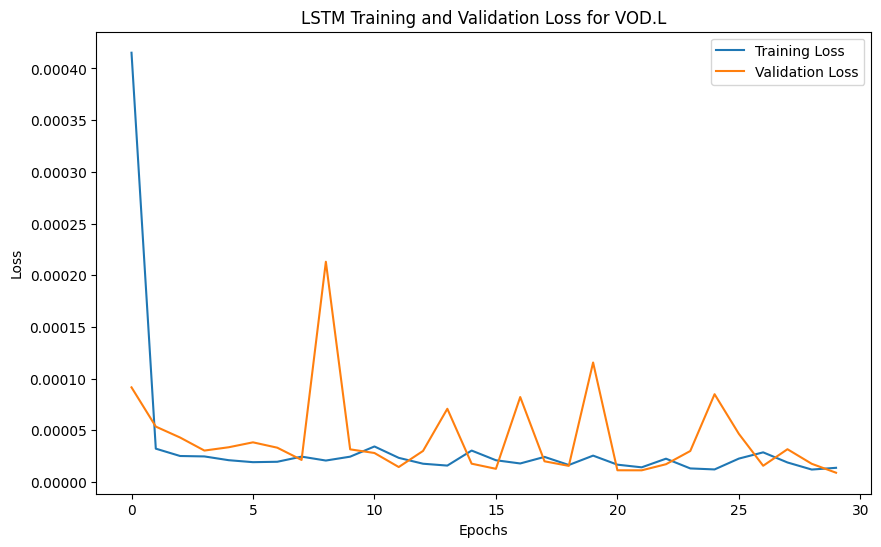

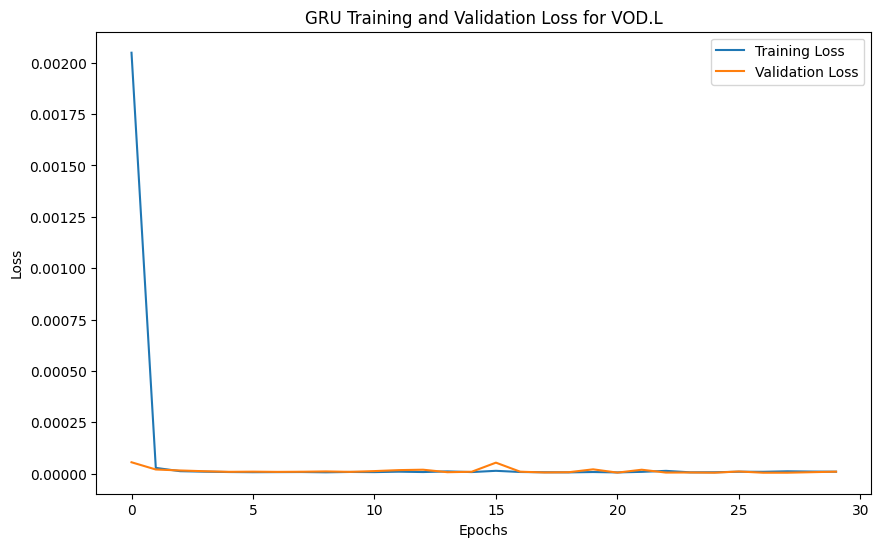

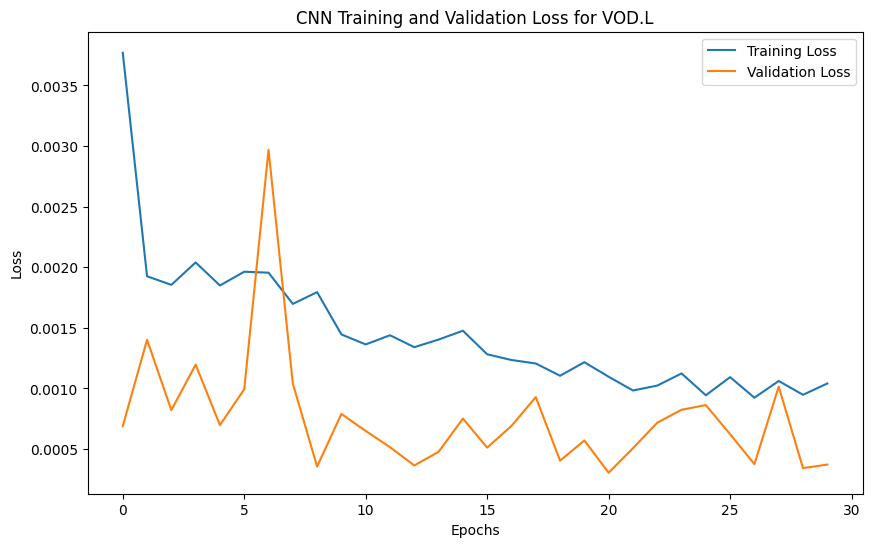

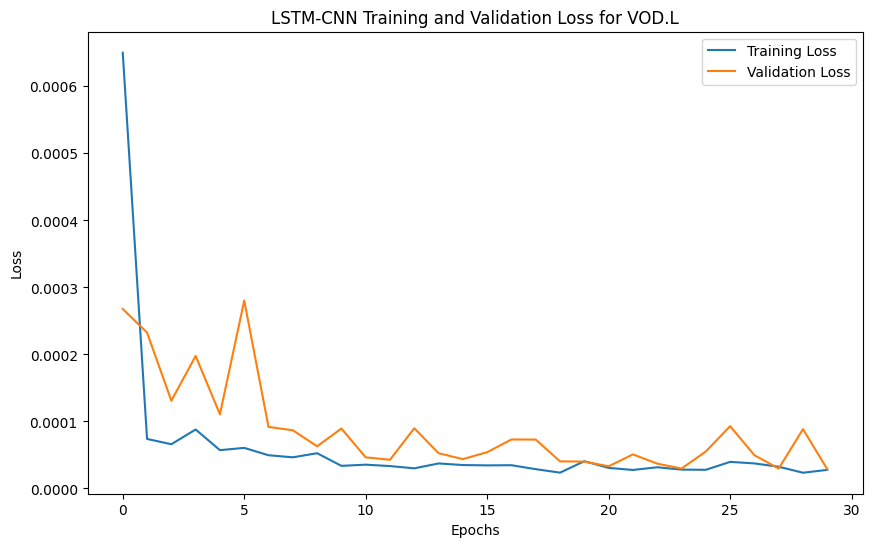

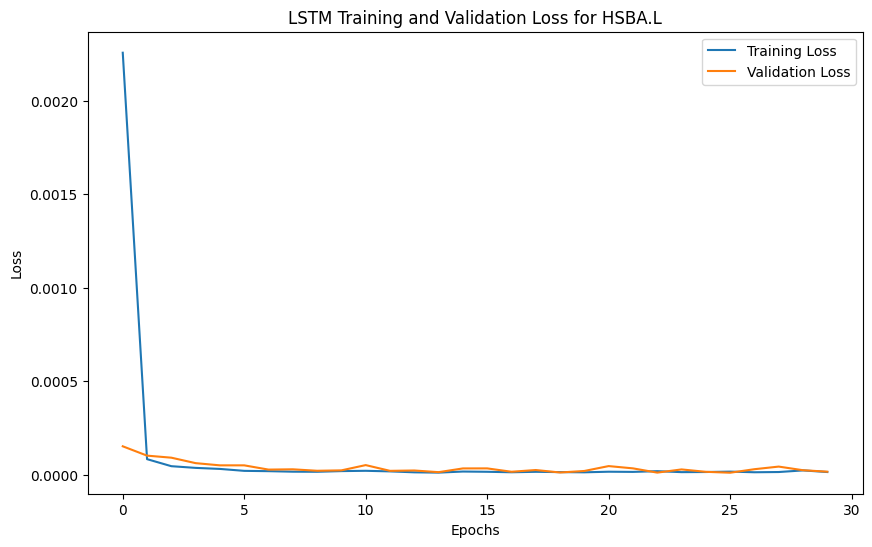

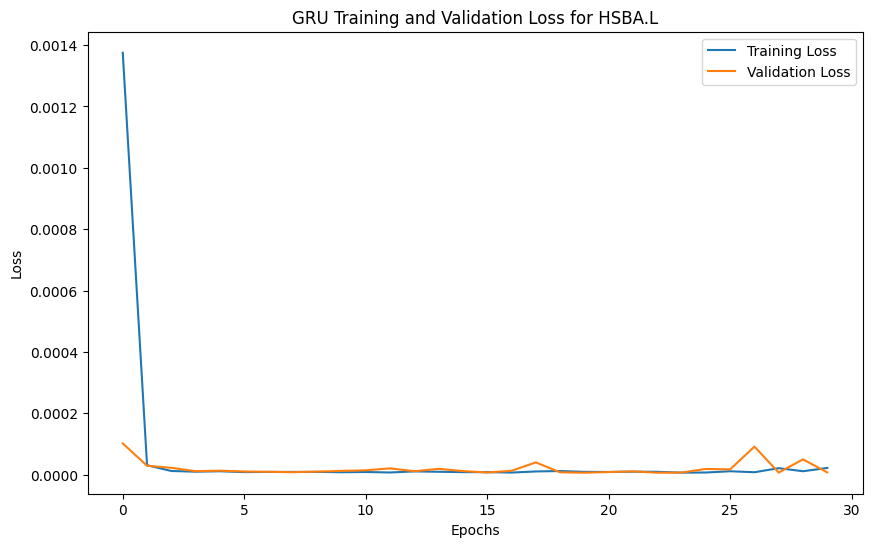

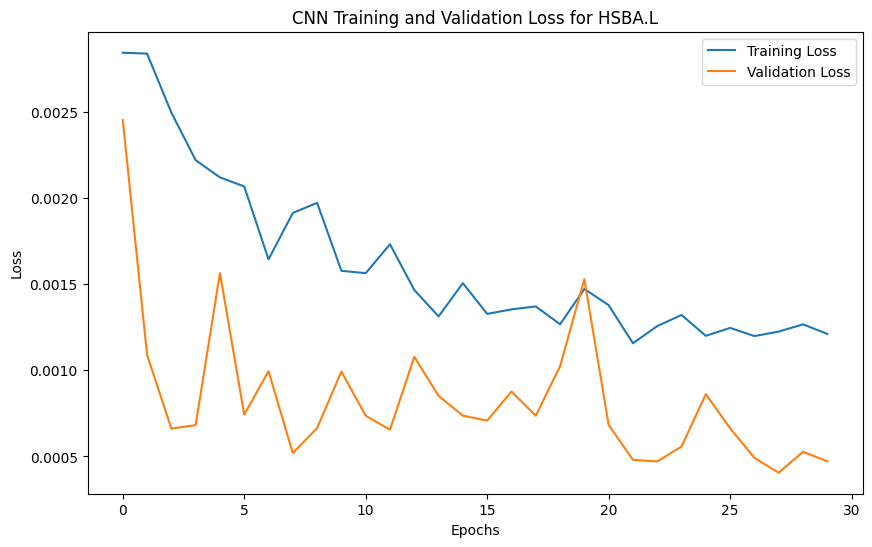

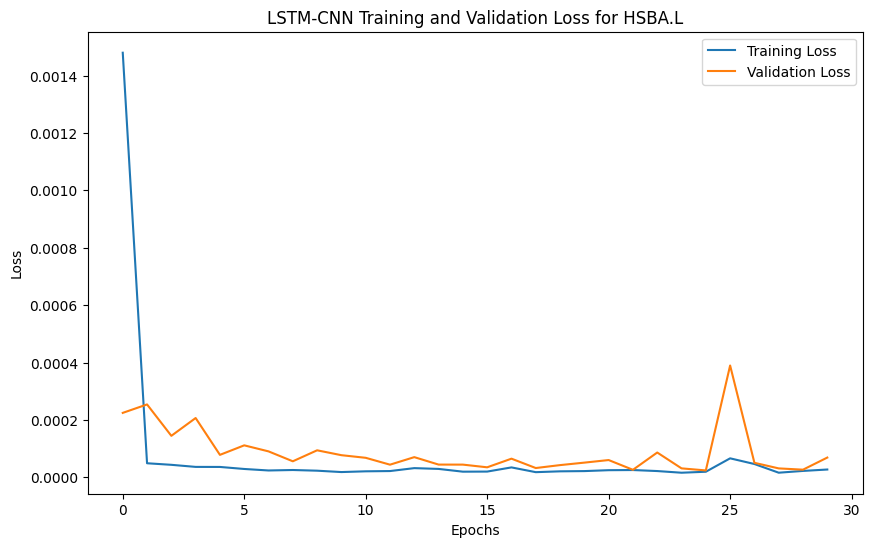

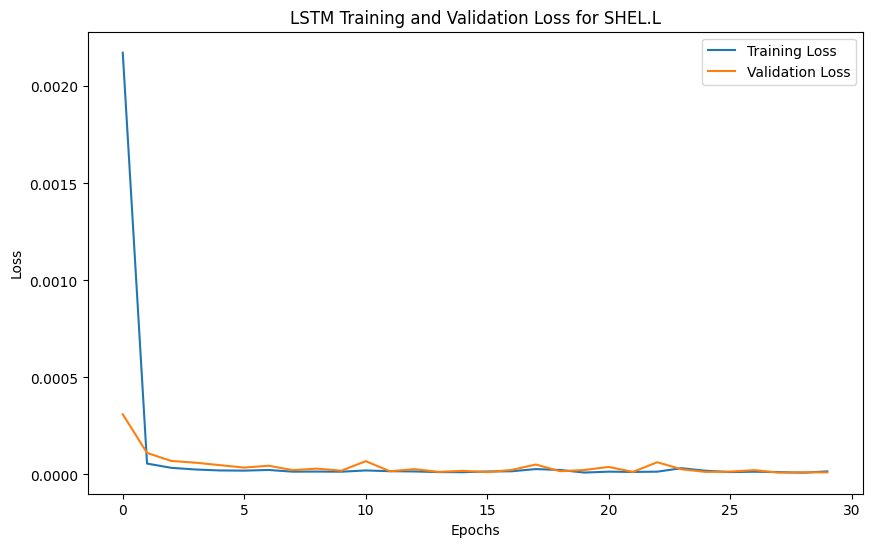

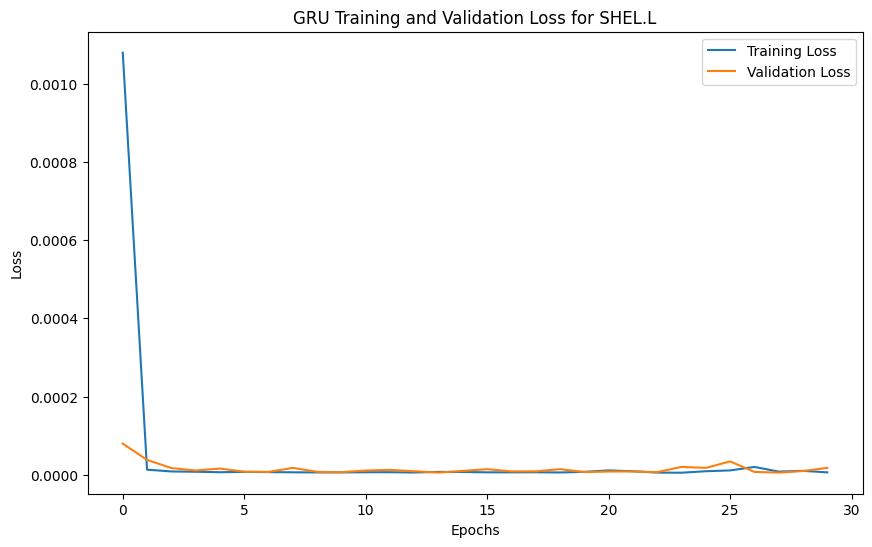

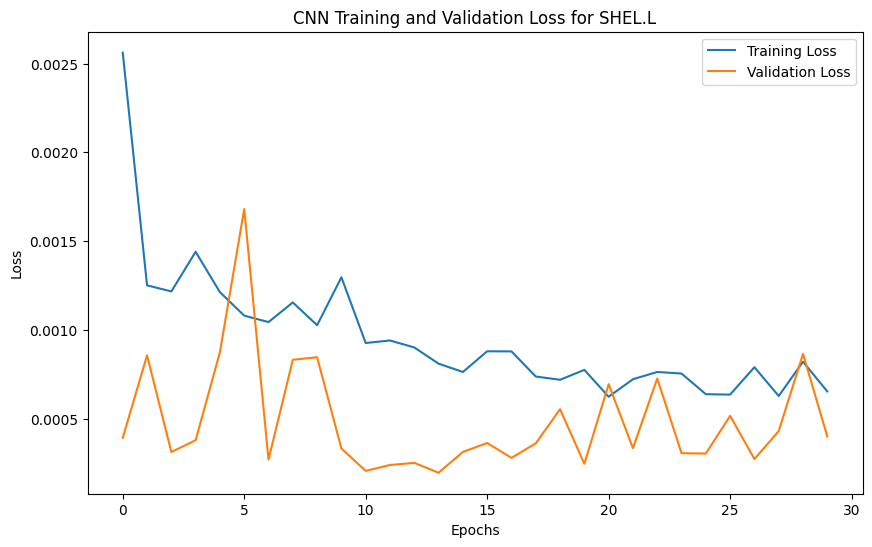

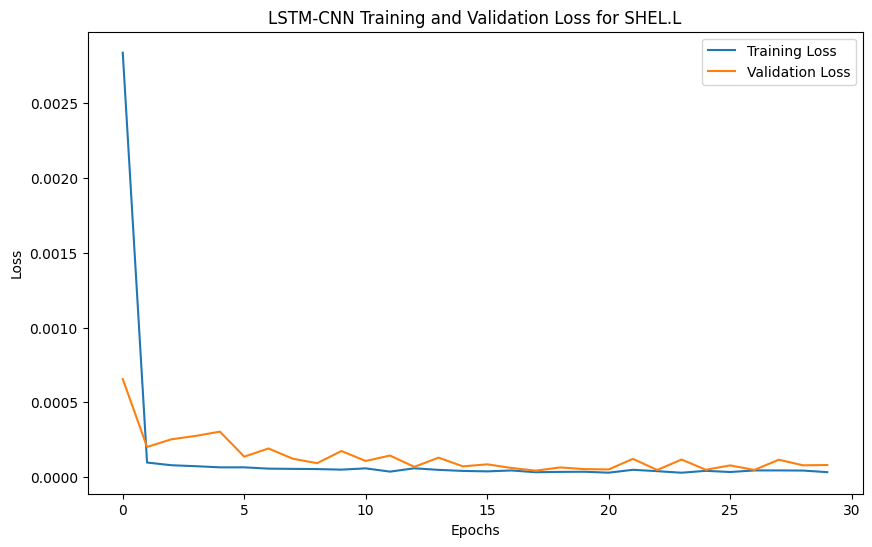

In [38]:
# Defining a function to plot training and validation loss
def plot_loss(history, model_name, stock_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss for {stock_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plotting loss for each model on VOD.L
plot_loss(history_lstm_VOD, 'LSTM', 'VOD.L')
plot_loss(history_gru_VOD, 'GRU', 'VOD.L')
plot_loss(history_cnn_VOD, 'CNN', 'VOD.L')
plot_loss(history_lstm_cnn_VOD, 'LSTM-CNN', 'VOD.L')

# Plotting for each model on HSBA.L
plot_loss(history_lstm_HSBA, 'LSTM', 'HSBA.L')
plot_loss(history_gru_HSBA, 'GRU', 'HSBA.L')
plot_loss(history_cnn_HSBA, 'CNN', 'HSBA.L')
plot_loss(history_lstm_cnn_HSBA, 'LSTM-CNN', 'HSBA.L')

# Plotting for each model on SHEL.L
plot_loss(history_lstm_SHEL, 'LSTM', 'SHEL.L')
plot_loss(history_gru_SHEL, 'GRU', 'SHEL.L')
plot_loss(history_cnn_SHEL, 'CNN', 'SHEL.L')
plot_loss(history_lstm_cnn_SHEL, 'LSTM-CNN', 'SHEL.L')


In [39]:
# Predicting on test data for VOD.L
y_pred_lstm_VOD = best_lstm_model_VOD.predict(X_test_VOD)
y_pred_gru_VOD = best_gru_model_VOD.predict(X_test_VOD)
y_pred_cnn_VOD = best_cnn_model_VOD.predict(X_test_VOD)
y_pred_lstm_cnn_VOD = best_lstm_cnn_model_VOD.predict(X_test_VOD)

# Inverse transform predictions and actuals for VOD.L
y_test_rescaled_VOD = scaler_VOD.inverse_transform(np.c_[y_test_VOD, np.zeros((len(y_test_VOD), len(features)-1))])[:, 0]
y_pred_lstm_rescaled_VOD = scaler_VOD.inverse_transform(np.c_[y_pred_lstm_VOD, np.zeros((len(y_pred_lstm_VOD), len(features)-1))])[:, 0]
y_pred_gru_rescaled_VOD = scaler_VOD.inverse_transform(np.c_[y_pred_gru_VOD, np.zeros((len(y_pred_gru_VOD), len(features)-1))])[:, 0]
y_pred_cnn_rescaled_VOD = scaler_VOD.inverse_transform(np.c_[y_pred_cnn_VOD, np.zeros((len(y_pred_cnn_VOD), len(features)-1))])[:, 0]
y_pred_lstm_cnn_rescaled_VOD = scaler_VOD.inverse_transform(np.c_[y_pred_lstm_cnn_VOD, np.zeros((len(y_pred_lstm_cnn_VOD), len(features)-1))])[:, 0]

# Predicting and rescaling for HSBA.L
y_pred_lstm_HSBA = best_lstm_model_HSBA.predict(X_test_HSBA)
y_pred_gru_HSBA = best_gru_model_HSBA.predict(X_test_HSBA)
y_pred_cnn_HSBA = best_cnn_model_HSBA.predict(X_test_HSBA)
y_pred_lstm_cnn_HSBA = best_lstm_cnn_model_HSBA.predict(X_test_HSBA)

y_test_rescaled_HSBA = scaler_HSBA.inverse_transform(np.c_[y_test_HSBA, np.zeros((len(y_test_HSBA), len(features)-1))])[:, 0]
y_pred_lstm_rescaled_HSBA = scaler_HSBA.inverse_transform(np.c_[y_pred_lstm_HSBA, np.zeros((len(y_pred_lstm_HSBA), len(features)-1))])[:, 0]
y_pred_gru_rescaled_HSBA = scaler_HSBA.inverse_transform(np.c_[y_pred_gru_HSBA, np.zeros((len(y_pred_gru_HSBA), len(features)-1))])[:, 0]
y_pred_cnn_rescaled_HSBA = scaler_HSBA.inverse_transform(np.c_[y_pred_cnn_HSBA, np.zeros((len(y_pred_cnn_HSBA), len(features)-1))])[:, 0]
y_pred_lstm_cnn_rescaled_HSBA = scaler_HSBA.inverse_transform(np.c_[y_pred_lstm_cnn_HSBA, np.zeros((len(y_pred_lstm_cnn_HSBA), len(features)-1))])[:, 0]

# Predicting and rescaling for SHEL.L
y_pred_lstm_SHEL = best_lstm_model_SHEL.predict(X_test_SHEL)
y_pred_gru_SHEL = best_gru_model_SHEL.predict(X_test_SHEL)
y_pred_cnn_SHEL = best_cnn_model_SHEL.predict(X_test_SHEL)
y_pred_lstm_cnn_SHEL = best_lstm_cnn_model_SHEL.predict(X_test_SHEL)

y_test_rescaled_SHEL = scaler_SHEL.inverse_transform(np.c_[y_test_SHEL, np.zeros((len(y_test_SHEL), len(features)-1))])[:, 0]
y_pred_lstm_rescaled_SHEL = scaler_SHEL.inverse_transform(np.c_[y_pred_lstm_SHEL, np.zeros((len(y_pred_lstm_SHEL), len(features)-1))])[:, 0]
y_pred_gru_rescaled_SHEL = scaler_SHEL.inverse_transform(np.c_[y_pred_gru_SHEL, np.zeros((len(y_pred_gru_SHEL), len(features)-1))])[:, 0]
y_pred_cnn_rescaled_SHEL = scaler_SHEL.inverse_transform(np.c_[y_pred_cnn_SHEL, np.zeros((len(y_pred_cnn_SHEL), len(features)-1))])[:, 0]
y_pred_lstm_cnn_rescaled_SHEL = scaler_SHEL.inverse_transform(np.c_[y_pred_lstm_cnn_SHEL, np.zeros((len(y_pred_lstm_cnn_SHEL), len(features)-1))])[:, 0]


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


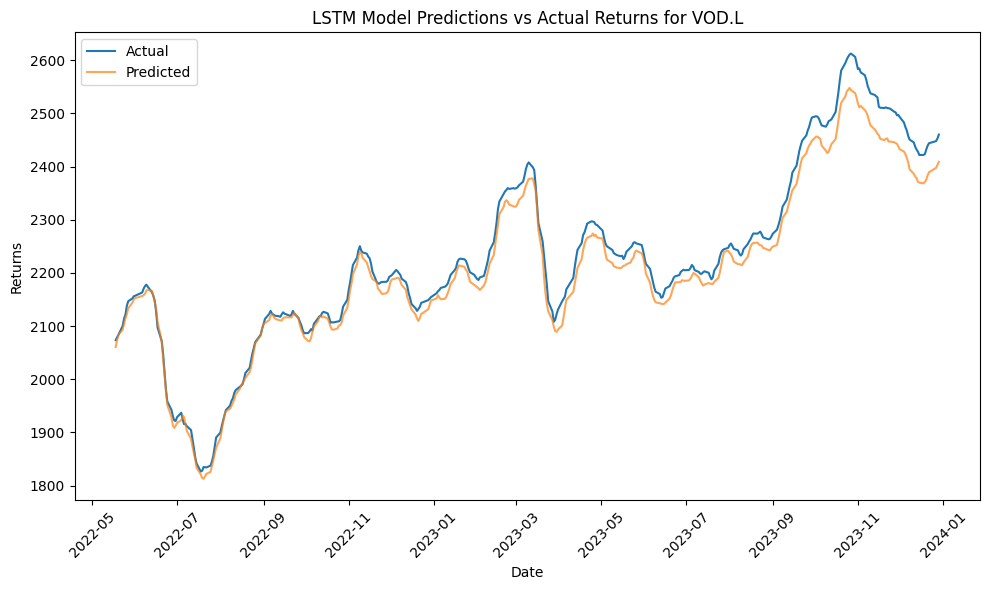

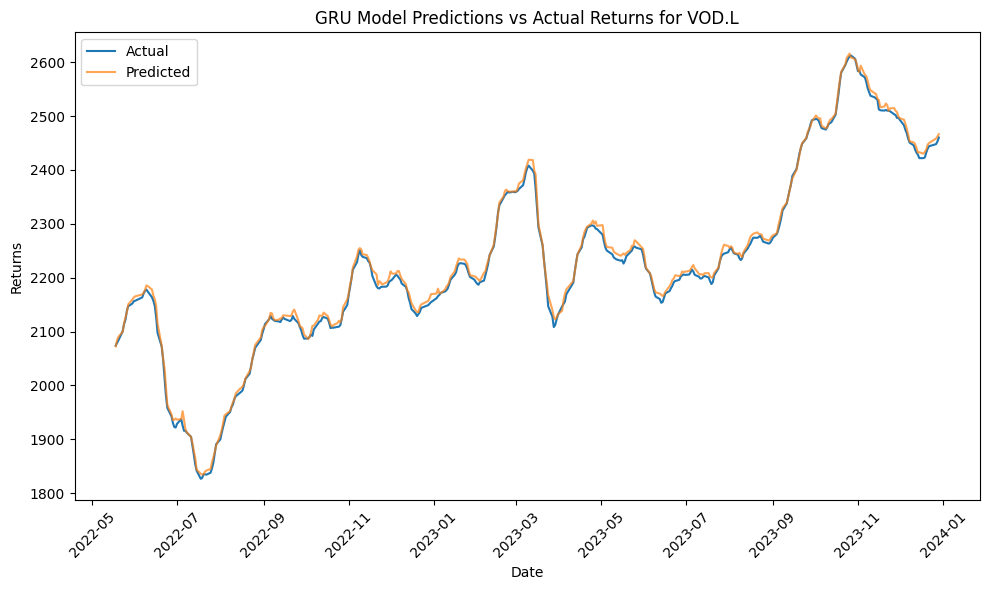

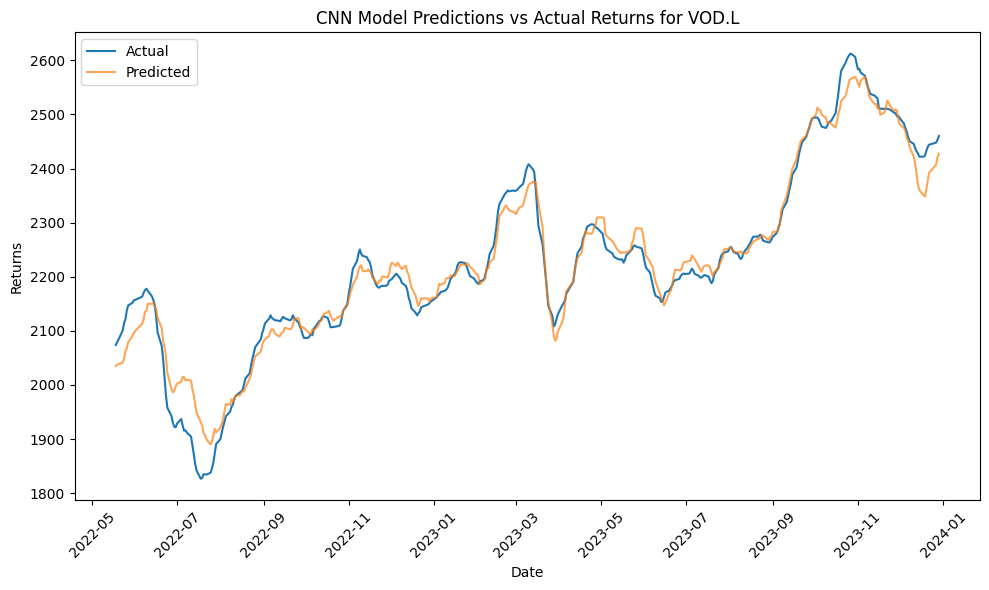

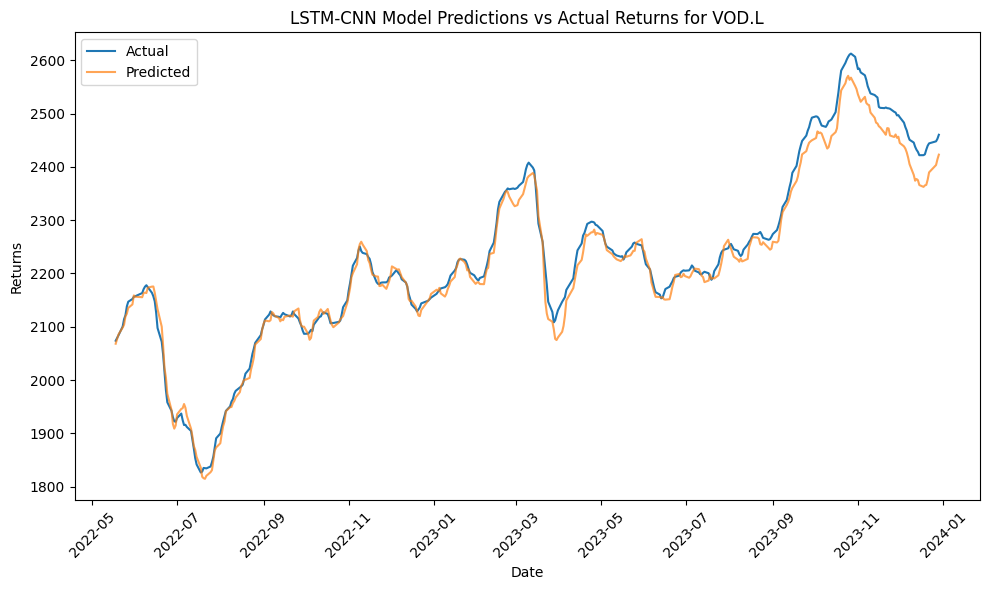

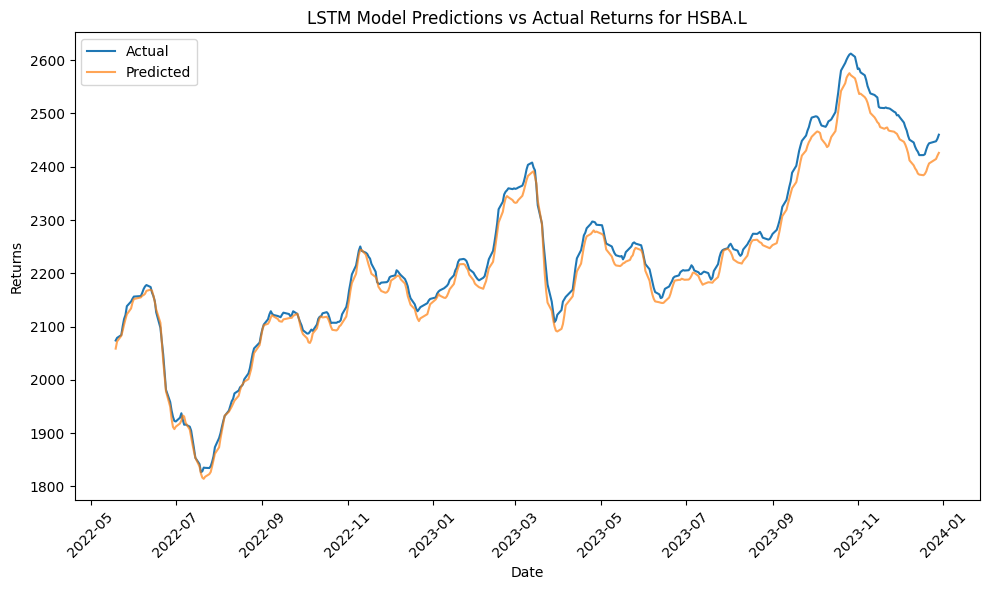

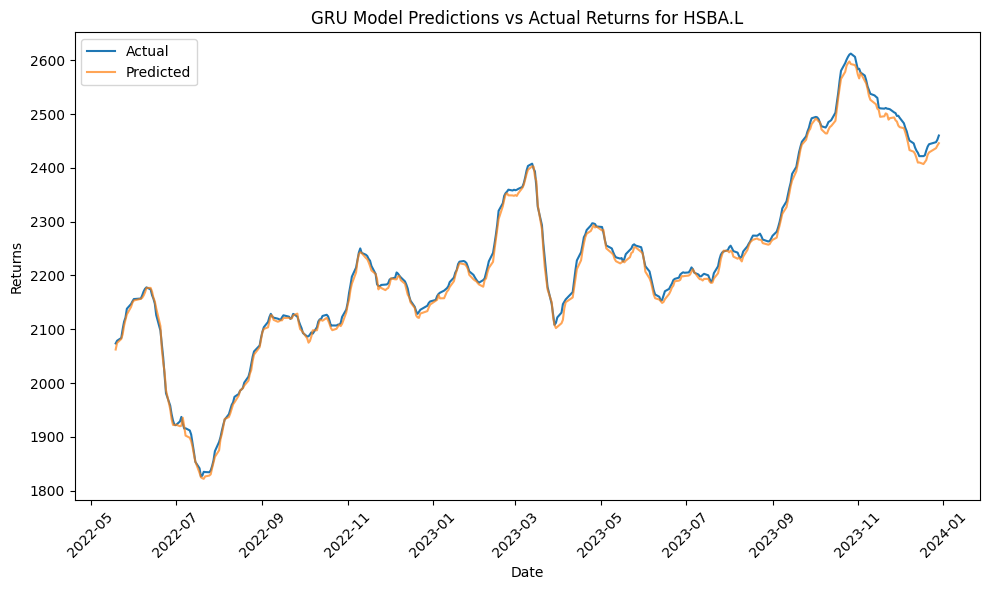

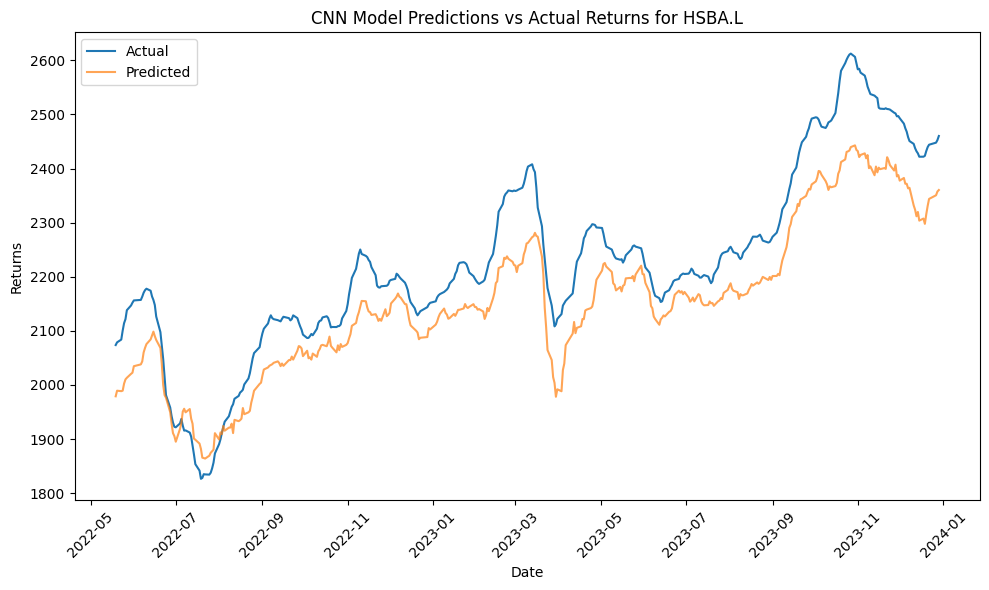

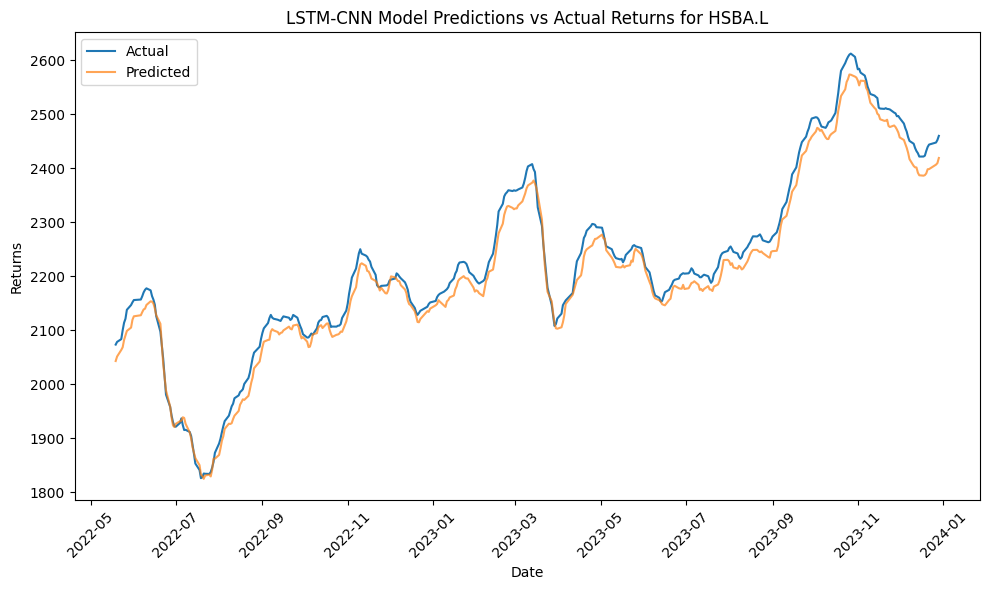

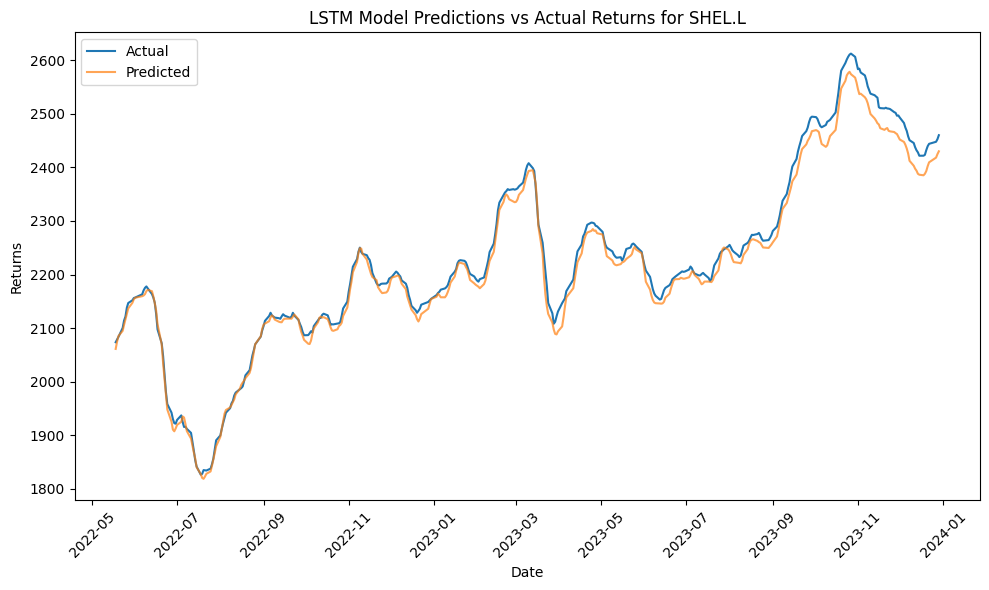

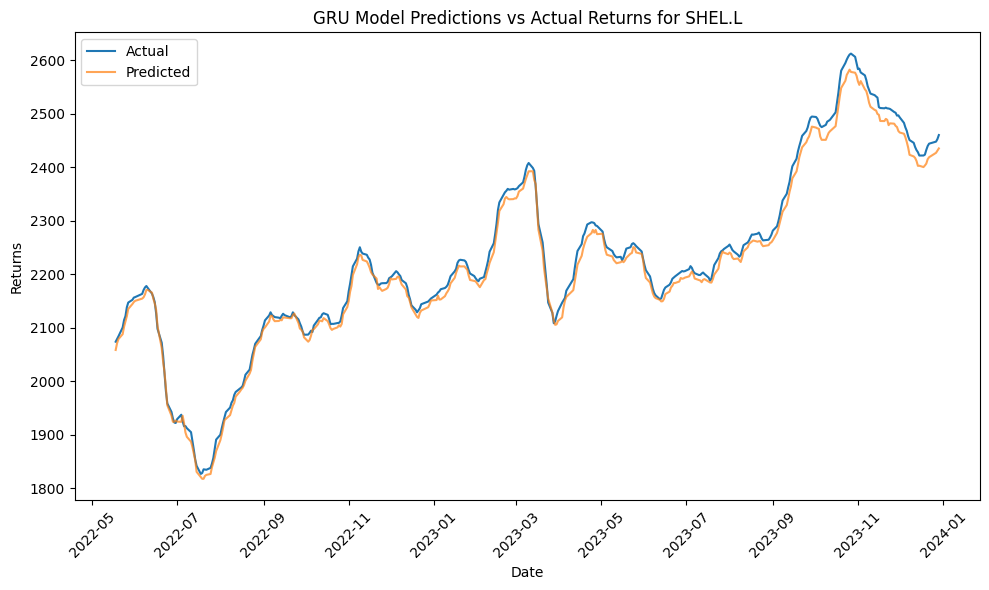

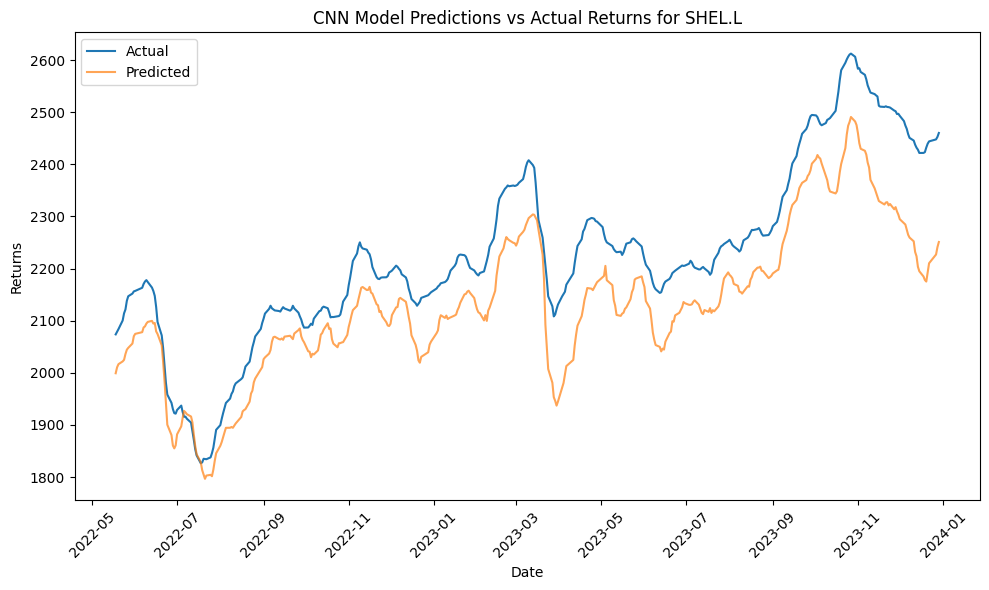

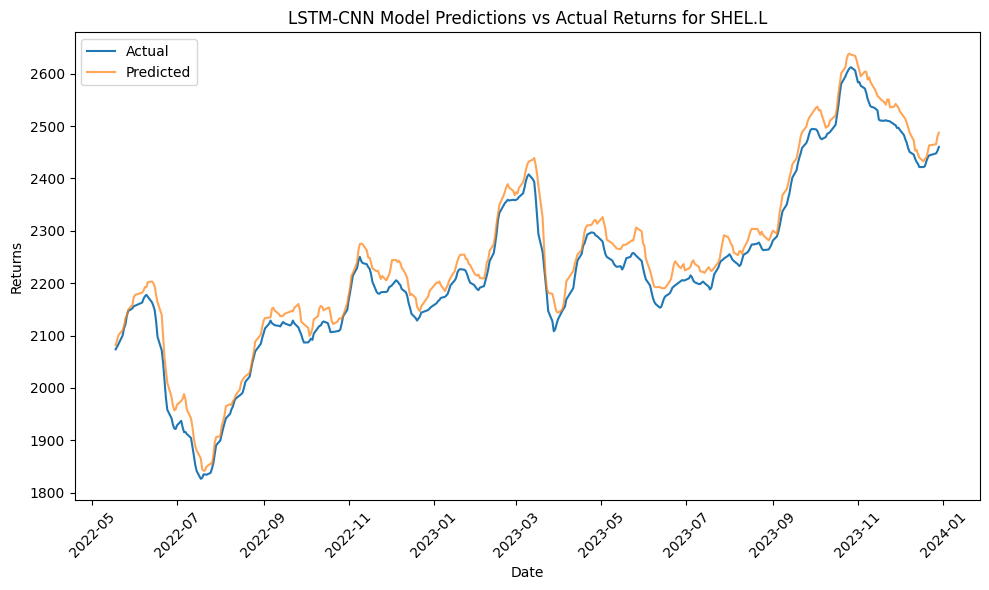

In [40]:
# Function to plot predictions vs actual values
def plot_predictions(y_test_rescaled, y_pred_rescaled, title, dates):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_test_rescaled, label='Actual')
    plt.plot(dates, y_pred_rescaled, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Align dates with test data for VOD.L
dates_VOD = stock_data_vod['Date'].values[-len(y_test_rescaled_VOD):]

# Plot predictions for each model on VOD.L
plot_predictions(y_test_rescaled_VOD, y_pred_lstm_rescaled_VOD, 'LSTM Model Predictions vs Actual Returns for VOD.L', dates_VOD)
plot_predictions(y_test_rescaled_VOD, y_pred_gru_rescaled_VOD, 'GRU Model Predictions vs Actual Returns for VOD.L', dates_VOD)
plot_predictions(y_test_rescaled_VOD, y_pred_cnn_rescaled_VOD, 'CNN Model Predictions vs Actual Returns for VOD.L', dates_VOD)
plot_predictions(y_test_rescaled_VOD, y_pred_lstm_cnn_rescaled_VOD, 'LSTM-CNN Model Predictions vs Actual Returns for VOD.L', dates_VOD)

# Similarly, align dates and plot for HSBA.L
dates_HSBA = stock_data_hsba['Date'].values[-len(y_test_rescaled_HSBA):]

plot_predictions(y_test_rescaled_HSBA, y_pred_lstm_rescaled_HSBA, 'LSTM Model Predictions vs Actual Returns for HSBA.L', dates_HSBA)
plot_predictions(y_test_rescaled_HSBA, y_pred_gru_rescaled_HSBA, 'GRU Model Predictions vs Actual Returns for HSBA.L', dates_HSBA)
plot_predictions(y_test_rescaled_HSBA, y_pred_cnn_rescaled_HSBA, 'CNN Model Predictions vs Actual Returns for HSBA.L', dates_HSBA)
plot_predictions(y_test_rescaled_HSBA, y_pred_lstm_cnn_rescaled_HSBA, 'LSTM-CNN Model Predictions vs Actual Returns for HSBA.L', dates_HSBA)

# Similarly, align dates and plot for SHEL.L
dates_SHEL = stock_data_shel['Date'].values[-len(y_test_rescaled_SHEL):]

plot_predictions(y_test_rescaled_SHEL, y_pred_lstm_rescaled_SHEL, 'LSTM Model Predictions vs Actual Returns for SHEL.L', dates_SHEL)
plot_predictions(y_test_rescaled_SHEL, y_pred_gru_rescaled_SHEL, 'GRU Model Predictions vs Actual Returns for SHEL.L', dates_SHEL)
plot_predictions(y_test_rescaled_SHEL, y_pred_cnn_rescaled_SHEL, 'CNN Model Predictions vs Actual Returns for SHEL.L', dates_SHEL)
plot_predictions(y_test_rescaled_SHEL, y_pred_lstm_cnn_rescaled_SHEL, 'LSTM-CNN Model Predictions vs Actual Returns for SHEL.L', dates_SHEL)


**EVALUATION** **METRICS** **FOR** **ALL** **THE** **MODELS** **FOR** **EACH** **STOCK**



In [41]:
# Function to evaluate model performance
def evaluate_model(y_test_rescaled, y_pred_rescaled):
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Evaluating models for VOD.L
mae_lstm_VOD, mse_lstm_VOD, rmse_lstm_VOD = evaluate_model(y_test_rescaled_VOD, y_pred_lstm_rescaled_VOD)
mae_gru_VOD, mse_gru_VOD, rmse_gru_VOD = evaluate_model(y_test_rescaled_VOD, y_pred_gru_rescaled_VOD)
mae_cnn_VOD, mse_cnn_VOD, rmse_cnn_VOD = evaluate_model(y_test_rescaled_VOD, y_pred_cnn_rescaled_VOD)
mae_lstm_cnn_VOD, mse_lstm_cnn_VOD, rmse_lstm_cnn_VOD = evaluate_model(y_test_rescaled_VOD, y_pred_lstm_cnn_rescaled_VOD)

# Evaluating models for HSBA.L
mae_lstm_HSBA, mse_lstm_HSBA, rmse_lstm_HSBA = evaluate_model(y_test_rescaled_HSBA, y_pred_lstm_rescaled_HSBA)
mae_gru_HSBA, mse_gru_HSBA, rmse_gru_HSBA = evaluate_model(y_test_rescaled_HSBA, y_pred_gru_rescaled_HSBA)
mae_cnn_HSBA, mse_cnn_HSBA, rmse_cnn_HSBA = evaluate_model(y_test_rescaled_HSBA, y_pred_cnn_rescaled_HSBA)
mae_lstm_cnn_HSBA, mse_lstm_cnn_HSBA, rmse_lstm_cnn_HSBA = evaluate_model(y_test_rescaled_HSBA, y_pred_lstm_cnn_rescaled_HSBA)

# Evaluating models for SHEL.L
mae_lstm_SHEL, mse_lstm_SHEL, rmse_lstm_SHEL = evaluate_model(y_test_rescaled_SHEL, y_pred_lstm_rescaled_SHEL)
mae_gru_SHEL, mse_gru_SHEL, rmse_gru_SHEL = evaluate_model(y_test_rescaled_SHEL, y_pred_gru_rescaled_SHEL)
mae_cnn_SHEL, mse_cnn_SHEL, rmse_cnn_SHEL = evaluate_model(y_test_rescaled_SHEL, y_pred_cnn_rescaled_SHEL)
mae_lstm_cnn_SHEL, mse_lstm_cnn_SHEL, rmse_lstm_cnn_SHEL = evaluate_model(y_test_rescaled_SHEL, y_pred_lstm_cnn_rescaled_SHEL)

# Creating a DataFrame to store the results
results_df = pd.DataFrame({
    'Stock': ['VOD.L', 'VOD.L', 'VOD.L', 'VOD.L', 'HSBA.L', 'HSBA.L', 'HSBA.L', 'HSBA.L', 'SHEL.L', 'SHEL.L', 'SHEL.L', 'SHEL.L'],
    'Model': ['LSTM', 'GRU', 'CNN', 'LSTM-CNN', 'LSTM', 'GRU', 'CNN', 'LSTM-CNN', 'LSTM', 'GRU', 'CNN', 'LSTM-CNN'],
    'MAE': [mae_lstm_VOD, mae_gru_VOD, mae_cnn_VOD, mae_lstm_cnn_VOD, mae_lstm_HSBA, mae_gru_HSBA, mae_cnn_HSBA, mae_lstm_cnn_HSBA, mae_lstm_SHEL, mae_gru_SHEL, mae_cnn_SHEL, mae_lstm_cnn_SHEL],
    'MSE': [mse_lstm_VOD, mse_gru_VOD, mse_cnn_VOD, mse_lstm_cnn_VOD, mse_lstm_HSBA, mse_gru_HSBA, mse_cnn_HSBA, mse_lstm_cnn_HSBA, mse_lstm_SHEL, mse_gru_SHEL, mse_cnn_SHEL, mse_lstm_cnn_SHEL],
    'RMSE': [rmse_lstm_VOD, rmse_gru_VOD, rmse_cnn_VOD, rmse_lstm_cnn_VOD, rmse_lstm_HSBA, rmse_gru_HSBA, rmse_cnn_HSBA, rmse_lstm_cnn_HSBA, rmse_lstm_SHEL, rmse_gru_SHEL, rmse_cnn_SHEL, rmse_lstm_cnn_SHEL  ]
})

# Displaying the results
results_df


,Stock,Model,MAE,MSE,RMSE
0,VOD.L,LSTM,22.685369,799.749377,28.279840
1,VOD.L,GRU,6.786111,67.302548,8.203813
2,VOD.L,CNN,22.677179,982.730597,31.348534
3,VOD.L,LSTM-CNN,17.248826,530.769504,23.038435
4,HSBA.L,LSTM,17.434873,426.701087,20.656744
5,HSBA.L,GRU,7.677343,79.341790,8.907401
6,HSBA.L,CNN,76.595843,7307.841725,85.485915
7,HSBA.L,LSTM-CNN,21.341331,568.943330,23.852533
8,SHEL.L,LSTM,15.004267,355.764206,18.861713
9,SHEL.L,GRU,13.276487,226.440463,15.047939
